In [ ]:
!pip install pdpbox
!pip install shap
!pip install eli5
!pip install category_encoders

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/MA_Public_Schools_2017.csv')

In [11]:
#pd.set_option('display.max_columns', None)

In [12]:
#for i in df.columns:
 # print(i)

In [13]:
df.shape

(1861, 302)

In [14]:
df.duplicated(subset = 'School Code').sum() #중복 데이터 없음

0

In [15]:
df.drop(df['PK' == df.Grade].index, inplace = True)

In [16]:
df.shape

(1805, 302)

In [17]:
key = df.iloc[:,0] #foreign key

School = pd.concat([key, df.iloc[:,1:14]], axis = 1)
Enrollment = pd.concat([key, df[[col for col in df.columns if 'Enrollment' in col]]], axis = 1)
Students = pd.concat([key, df[['First Language Not English',	'% First Language Not English',	'English Language Learner',	'% English Language Learner',	'Students With Disabilities',	'% Students With Disabilities',	'High Needs',	'% High Needs',	'Economically Disadvantaged',	'% Economically Disadvantaged',	'% African American',	'% Asian',	'% Hispanic',	'% White',	'% Native American',	'% Native Hawaiian, Pacific Islander',	'% Multi-Race, Non-Hispanic',	'% Males',	'% Females',	'Total # of Classes',	'Average Class Size',	'Number of Students']]], axis = 1)
Salary = pd.concat([key, df[['Salary Totals',	'Average Salary',	'FTE Count',	'In-District Expenditures',	'Total In-district FTEs',	'Average In-District Expenditures per Pupil',	'Total Expenditures',	'Total Pupil FTEs',	'Average Expenditures per Pupil']]], axis = 1)
Students_2 = pd.concat([key, df.iloc[:,62:79]], axis = 1)
AP = pd.concat([key, df[[col for col in df.columns if 'AP' in col]]], axis = 1)
SAT = pd.concat([key, df[[col for col in df.columns if 'SAT' in col]]], axis = 1)
MCAS = pd.concat([key, df[[col for col in df.columns if 'MCAS' in col]]], axis = 1)
Level = pd.concat([key, df.iloc[:,293:]], axis = 1)


In [18]:
def displ(li):
  for data in li:
    display(data.head()), display(data.info())
    print('='*20)
lis = [School, Enrollment, Students, Salary, Students_2, AP, SAT, MCAS, Level]

In [19]:
displ(lis)

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,Phone,Fax,Grade,District Name
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,781-982-2160,781-982-0061,"09,10,11,12",Abington
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,781-982-2185,781-982-2187,"01,02,03,04",Abington
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,781-982-2195,781-982-0053,"PK,K",Abington
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,781-982-2170,781-982-2173,"07,08",Abington
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,781-982-2180,781-982-2184,"05,06",Abington


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   School Code    1805 non-null   int64 
 1   School Name    1805 non-null   object
 2   School Type    1805 non-null   object
 3   Function       1805 non-null   object
 4   Contact Name   1805 non-null   object
 5   Address 1      1805 non-null   object
 6   Address 2      29 non-null     object
 7   Town           1805 non-null   object
 8   State          1805 non-null   object
 9   Zip            1805 non-null   int64 
 10  Phone          1805 non-null   object
 11  Fax            1805 non-null   object
 12  Grade          1804 non-null   object
 13  District Name  1805 non-null   object
dtypes: int64(2), object(12)
memory usage: 211.5+ KB


None

,School Code,PK_Enrollment,K_Enrollment,1_Enrollment,2_Enrollment,3_Enrollment,4_Enrollment,5_Enrollment,6_Enrollment,7_Enrollment,8_Enrollment,9_Enrollment,10_Enrollment,11_Enrollment,12_Enrollment,SP_Enrollment,TOTAL_Enrollment
0,10505,0,0,0,0,0,0,0,0,0,0,124,109,123,92,4,452
1,10003,0,0,125,164,148,143,0,0,0,0,0,0,0,0,0,580
2,10002,69,134,0,0,0,0,0,0,0,0,0,0,0,0,0,203
3,10405,0,0,0,0,0,0,0,0,159,169,0,0,0,0,0,328
4,10015,0,0,0,0,0,0,180,173,0,0,0,0,0,0,0,353


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   School Code       1805 non-null   int64
 1   PK_Enrollment     1805 non-null   int64
 2   K_Enrollment      1805 non-null   int64
 3   1_Enrollment      1805 non-null   int64
 4   2_Enrollment      1805 non-null   int64
 5   3_Enrollment      1805 non-null   int64
 6   4_Enrollment      1805 non-null   int64
 7   5_Enrollment      1805 non-null   int64
 8   6_Enrollment      1805 non-null   int64
 9   7_Enrollment      1805 non-null   int64
 10  8_Enrollment      1805 non-null   int64
 11  9_Enrollment      1805 non-null   int64
 12  10_Enrollment     1805 non-null   int64
 13  11_Enrollment     1805 non-null   int64
 14  12_Enrollment     1805 non-null   int64
 15  SP_Enrollment     1805 non-null   int64
 16  TOTAL_Enrollment  1805 non-null   int64
dtypes: int64(17)
memory usage: 253.8 

None

,School Code,First Language Not English,% First Language Not English,English Language Learner,% English Language Learner,Students With Disabilities,% Students With Disabilities,High Needs,% High Needs,Economically Disadvantaged,...,% Hispanic,% White,% Native American,"% Native Hawaiian, Pacific Islander","% Multi-Race, Non-Hispanic",% Males,% Females,Total # of Classes,Average Class Size,Number of Students
0,10505,24.0,5.3,11.0,2.4,44.0,9.7,130.0,28.8,97.0,...,9.1,85.8,0.2,0.2,0.9,45.6,54.4,204.0,15.8,451.0
1,10003,61.0,10.5,42.0,7.2,77.0,13.3,215.0,37.1,135.0,...,6.7,88.4,0.5,0.2,0.3,50.2,49.8,325.0,24.6,643.0
2,10002,26.0,12.8,6.0,3.0,43.0,21.2,69.0,34.0,33.0,...,8.4,84.7,0.0,0.0,0.0,54.2,45.8,112.0,14.6,208.0
3,10405,18.0,5.5,6.0,1.8,43.0,13.1,101.0,30.8,71.0,...,6.1,89.3,0.0,0.0,0.3,53.4,46.6,218.0,21.1,342.0
4,10015,21.0,5.9,7.0,2.0,38.0,10.8,108.0,30.6,80.0,...,4.2,92.1,0.0,0.0,0.3,50.7,49.3,121.0,30.4,334.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   School Code                          1805 non-null   int64  
 1   First Language Not English           1794 non-null   float64
 2   % First Language Not English         1794 non-null   float64
 3   English Language Learner             1794 non-null   float64
 4   % English Language Learner           1794 non-null   float64
 5   Students With Disabilities           1794 non-null   float64
 6   % Students With Disabilities         1794 non-null   float64
 7   High Needs                           1794 non-null   float64
 8   % High Needs                         1794 non-null   float64
 9   Economically Disadvantaged           1794 non-null   float64
 10  % Economically Disadvantaged         1794 non-null   float64
 11  % African American            

None

,School Code,Salary Totals,Average Salary,FTE Count,In-District Expenditures,Total In-district FTEs,Average In-District Expenditures per Pupil,Total Expenditures,Total Pupil FTEs,Average Expenditures per Pupil
0,10505,9489496.0,74662.0,127.0,23365711.18,1939.0,12050.39,27229100.8,2051.8,13270.84
1,10003,9489496.0,74662.0,127.0,23365711.18,1939.0,12050.39,27229100.8,2051.8,13270.84
2,10002,9489496.0,74662.0,127.0,23365711.18,1939.0,12050.39,27229100.8,2051.8,13270.84
3,10405,9489496.0,74662.0,127.0,23365711.18,1939.0,12050.39,27229100.8,2051.8,13270.84
4,10015,9489496.0,74662.0,127.0,23365711.18,1939.0,12050.39,27229100.8,2051.8,13270.84


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   School Code                                 1805 non-null   int64  
 1   Salary Totals                               1713 non-null   float64
 2   Average Salary                              1713 non-null   float64
 3   FTE Count                                   1713 non-null   float64
 4   In-District Expenditures                    1712 non-null   float64
 5   Total In-district FTEs                      1712 non-null   float64
 6   Average In-District Expenditures per Pupil  1712 non-null   float64
 7   Total Expenditures                          1712 non-null   float64
 8   Total Pupil FTEs                            1712 non-null   float64
 9   Average Expenditures per Pupil              1712 non-null   float64
dtypes: float64(9

None

,School Code,# in Cohort,% Graduated,% Still in School,% Non-Grad Completers,% GED,% Dropped Out,% Permanently Excluded,High School Graduates (#),Attending Coll./Univ. (#),% Attending College,% Private Two-Year,% Private Four-Year,% Public Two-Year,% Public Four-Year,% MA Community College,% MA State University,% UMass
0,10505,114.0,94.7,0.9,0.0,0.9,3.5,0.0,124.0,94.0,75.8,1.1,22.3,30.9,45.7,30.9,19.1,9.6
1,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   School Code                1805 non-null   int64  
 1   # in Cohort                376 non-null    float64
 2   % Graduated                376 non-null    float64
 3   % Still in School          376 non-null    float64
 4   % Non-Grad Completers      376 non-null    float64
 5   % GED                      376 non-null    float64
 6   % Dropped Out              376 non-null    float64
 7   % Permanently Excluded     376 non-null    float64
 8   High School Graduates (#)  371 non-null    float64
 9   Attending Coll./Univ. (#)  344 non-null    float64
 10  % Attending College        344 non-null    float64
 11  % Private Two-Year         344 non-null    float64
 12  % Private Four-Year        344 non-null    float64
 13  % Public Two-Year          344 non-null    float

None

,School Code,AP_Test Takers,AP_Tests Taken,AP_One Test,AP_Two Tests,AP_Three Tests,AP_Four Tests,AP_Five or More Tests,AP_Score=1,AP_Score=2,AP_Score=3,AP_Score=4,AP_Score=5,% AP_Score 1-2,% AP_Score 3-5
0,10505,70,123,31.0,27.0,11.0,0.0,1.0,8.0,46.0,40.0,20.0,9.0,43.9,56.1
1,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   School Code            1805 non-null   int64  
 1   AP_Test Takers         310 non-null    object 
 2   AP_Tests Taken         302 non-null    object 
 3   AP_One Test            302 non-null    float64
 4   AP_Two Tests           302 non-null    float64
 5   AP_Three Tests         302 non-null    float64
 6   AP_Four Tests          302 non-null    float64
 7   AP_Five or More Tests  302 non-null    float64
 8   AP_Score=1             303 non-null    float64
 9   AP_Score=2             303 non-null    float64
 10  AP_Score=3             303 non-null    float64
 11  AP_Score=4             303 non-null    float64
 12  AP_Score=5             303 non-null    float64
 13  % AP_Score 1-2         303 non-null    float64
 14  % AP_Score 3-5         303 non-null    float64
dtypes: f

None

,School Code,SAT_Tests Taken,Average SAT_Reading,Average SAT_Writing,Average SAT_Math
0,10505,98.0,520.0,498.0,516.0
1,10003,NaN,NaN,NaN,NaN
2,10002,NaN,NaN,NaN,NaN
3,10405,NaN,NaN,NaN,NaN
4,10015,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   School Code          1805 non-null   int64  
 1   SAT_Tests Taken      360 non-null    float64
 2   Average SAT_Reading  332 non-null    float64
 3   Average SAT_Writing  332 non-null    float64
 4   Average SAT_Math     332 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 84.6 KB


None

,School Code,MCAS_3rdGrade_Math_P+A #,% MCAS_3rdGrade_Math_P+A,MCAS_3rdGrade_Math_A #,% MCAS_3rdGrade_Math_A,MCAS_3rdGrade_Math_P #,% MCAS_3rdGrade_Math_P,MCAS_3rdGrade_Math_NI #,% MCAS_3rdGrade_Math_NI,MCAS_3rdGrade_Math_W/F #,...,MCAS_10thGrade_English_P #,% MCAS_10thGrade_English_P,MCAS_10thGrade_English_NI #,% MCAS_10thGrade_English_NI,MCAS_10thGrade_English_W/F #,% MCAS_10thGrade_English_W/F,MCAS_10thGrade_English_Stud. Incl. #,MCAS_10thGrade_English_CPI,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#)
0,10505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.0,46.0,2.0,2.0,5.0,4.0,124.0,98.8,56.0,111.0
1,10003,92.0,66.0,41.0,29.0,51.0,36.0,36.0,26.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Columns: 197 entries, School Code to MCAS_10thGrade_English_Incl. in SGP(#)
dtypes: float64(196), int64(1)
memory usage: 2.7 MB


None

,School Code,Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1860
Data columns (total 10 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   School Code                                                          1805 non-null   int64  
 1   Accountability and Assistance Level                                  1781 non-null   object 
 2   Accountability and Assistance Description                            1607 non-null   object 
 3   School Accountability Percentile (1-99)                              1541 non-null   float64
 4   Progress and Performance Index (PPI) - All Students                  1591 non-null   float64
 5   Progress and Performance Index (PPI) - High Needs Students           1489 non-null   float64
 6   District_Accountability and Assistance Level                         1794 non-null   object 
 7   Distri

None

In [20]:
#School['Town'].unique()

In [21]:
#School['Function'].unique()

In [22]:
School.drop(['Function', 'Fax', 'Phone', 'Contact Name', 'State', 'Zip', 'Address 1', 'Address 2'], axis = 1, inplace = True)

In [23]:
#School.head()

In [24]:
#School.Grade

In [25]:
# School.drop(School['PK' == School.Grade].index)

In [26]:
TOTAL_Enrollment = Enrollment['TOTAL_Enrollment']

In [27]:
#TOTAL_Enrollment

In [28]:
#Students.head()

In [29]:
#Students

In [30]:
Students = pd.concat([Students, TOTAL_Enrollment], axis = 1)

In [31]:
#Students.info()

In [32]:
#Students

In [33]:
#Students.columns

In [34]:
Percent = [x for x in Students.columns if '%' in x]

In [35]:
Students_ml = Students.drop(Percent, axis = 1)

In [36]:
Students_ml.iloc[:,6:]

,Total # of Classes,Average Class Size,Number of Students,TOTAL_Enrollment
0,204.0,15.8,451.0,452
1,325.0,24.6,643.0,580
2,112.0,14.6,208.0,203
3,218.0,21.1,342.0,328
4,121.0,30.4,334.0,353
...,...,...,...,...
1856,124.0,18.8,267.0,322
1857,20.0,27.0,108.0,163
1858,383.0,25.7,1014.0,1119
1859,192.0,21.9,655.0,744


In [37]:
School2 = Students_ml.iloc[:,6:] #School2라고 이름 붙이는 게 좋겠음.

In [38]:
#School2.head()

In [39]:
Students_percent = pd.concat([key, Students[Percent]], axis = 1)

In [40]:
Students_percent

,School Code,% First Language Not English,% English Language Learner,% Students With Disabilities,% High Needs,% Economically Disadvantaged,% African American,% Asian,% Hispanic,% White,% Native American,"% Native Hawaiian, Pacific Islander","% Multi-Race, Non-Hispanic",% Males,% Females
0,10505,5.3,2.4,9.7,28.8,21.5,2.2,1.5,9.1,85.8,0.2,0.2,0.9,45.6,54.4
1,10003,10.5,7.2,13.3,37.1,23.3,1.9,1.9,6.7,88.4,0.5,0.2,0.3,50.2,49.8
2,10002,12.8,3.0,21.2,34.0,16.3,3.9,3.0,8.4,84.7,0.0,0.0,0.0,54.2,45.8
3,10405,5.5,1.8,13.1,30.8,21.6,2.4,1.8,6.1,89.3,0.0,0.0,0.3,53.4,46.6
4,10015,5.9,2.0,10.8,30.6,22.7,2.0,1.4,4.2,92.1,0.0,0.0,0.3,50.7,49.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,51.2,25.5,11.5,53.4,28.9,35.1,11.5,21.1,29.8,1.2,0.0,1.2,45.0,55.0
1857,35100205,25.8,25.8,4.3,76.7,70.6,24.5,1.8,64.4,6.1,0.0,0.0,3.1,50.9,49.1
1858,39020900,6.2,2.1,20.4,49.9,36.1,6.3,3.3,12.2,70.5,0.4,0.2,7.1,43.4,56.6
1859,35050405,38.3,21.1,19.5,78.0,63.2,56.7,1.6,38.0,1.1,0.4,0.0,2.2,49.2,50.8


In [41]:
#Students_2.info()

In [42]:
many_null = pd.concat([Students_2, AP.drop('School Code', axis = 1), SAT.drop('School Code', axis = 1)], axis = 1)

In [43]:
#many_null

In [44]:
li = [x for x in many_null.columns if 'SAT' in x]
test = pd.concat([many_null.iloc[:, 0], many_null[li]], axis = 1)

In [45]:
test = test.dropna().reset_index(drop = True)

In [46]:
test

,School Code,SAT_Tests Taken,Average SAT_Reading,Average SAT_Writing,Average SAT_Math
0,10505,98.0,520.0,498.0,516.0
1,50505,234.0,496.0,475.0,514.0
2,70505,115.0,531.0,518.0,534.0
3,90505,393.0,566.0,562.0,581.0
4,100505,271.0,581.0,576.0,592.0
...,...,...,...,...,...
327,3480285,37.0,435.0,428.0,471.0
328,3480605,209.0,432.0,422.0,437.0
329,39010900,13.0,532.0,505.0,515.0
330,35010505,32.0,413.0,410.0,410.0


In [47]:
many_null = pd.concat([many_null.iloc[:,0], many_null.drop(test.columns, axis = 1)], axis = 1)

In [48]:
many_null

,School Code,# in Cohort,% Graduated,% Still in School,% Non-Grad Completers,% GED,% Dropped Out,% Permanently Excluded,High School Graduates (#),Attending Coll./Univ. (#),...,AP_Three Tests,AP_Four Tests,AP_Five or More Tests,AP_Score=1,AP_Score=2,AP_Score=3,AP_Score=4,AP_Score=5,% AP_Score 1-2,% AP_Score 3-5
0,10505,114.0,94.7,0.9,0.0,0.9,3.5,0.0,124.0,94.0,...,11.0,0.0,1.0,8.0,46.0,40.0,20.0,9.0,43.9,56.1
1,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,3.0,9.0,7.0,1.0,7.0,44.4,55.6
1857,35100205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,39020900,138.0,31.2,26.8,0.0,12.3,29.7,0.0,13.0,NaN,...,1.0,0.0,0.0,1.0,8.0,5.0,2.0,1.0,52.9,47.1
1859,35050405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
                                                     #School, Students, Students_percent, many_null, test, Level, Salary

In [50]:
School2

,Total # of Classes,Average Class Size,Number of Students,TOTAL_Enrollment
0,204.0,15.8,451.0,452
1,325.0,24.6,643.0,580
2,112.0,14.6,208.0,203
3,218.0,21.1,342.0,328
4,121.0,30.4,334.0,353
...,...,...,...,...
1856,124.0,18.8,267.0,322
1857,20.0,27.0,108.0,163
1858,383.0,25.7,1014.0,1119
1859,192.0,21.9,655.0,744


In [51]:
School = pd.concat([School, School2], axis = 1)
School.head()

(1805, 10)

In [53]:
School.head()

,School Code,School Name,School Type,Town,Grade,District Name,Total # of Classes,Average Class Size,Number of Students,TOTAL_Enrollment
0,10505,Abington High,Public School,Abington,"09,10,11,12",Abington,204.0,15.8,451.0,452
1,10003,Beaver Brook Elementary School,Public School,Abington,"01,02,03,04",Abington,325.0,24.6,643.0,580
2,10002,Center Elementary School,Public School,Abington,"PK,K",Abington,112.0,14.6,208.0,203
3,10405,Frolio Middle School,Public School,Abington,"07,08",Abington,218.0,21.1,342.0,328
4,10015,Woodsdale Elementary School,Public School,Abington,"05,06",Abington,121.0,30.4,334.0,353


In [ ]:
#School.info()

In [ ]:
#School.isna().sum()

In [56]:
School = School.fillna(method = 'bfill').fillna(method = 'ffill') #별 영향력 없는 변수라서 대충 메움

In [ ]:
li = [x for x in MCAS.columns if '%' in x]

In [ ]:
MCAS_percent = MCAS[li]

In [57]:
grade_min = []
grade_max = []

for i, grade in enumerate(School.Grade):
  g_min = grade.split(',')[0]
  g_max = grade.split(',')[-1]
  grade_min.append(g_min)
  grade_max.append(g_max)
  

In [58]:
School['grade_min'] = grade_min
School['grade_max'] = grade_max

In [59]:
School.drop('Grade', axis = 1, inplace = True)

In [60]:
def func(x):
  if x == 'K':
    return 0
  elif x == 'PK':
    return -1
  else:
    return int(x)

In [61]:
School.grade_min = School.grade_min.map(func)
School.grade_max = School.grade_max.map(func)

In [62]:
def Grade(x):
  if -1 <= x <= 0:
    return 'K'
  elif 0 < x <= 5:
    return 'E'
  elif 6 <= x <= 8:
    return 'M'
  else:
    return 'H'

In [63]:
School.grade_min = School.grade_min.map(Grade)
School.grade_max = School.grade_max.map(Grade)

In [69]:
School.reset_index(drop = True, inplace = True)

In [68]:
len(School)

1805

In [71]:
li = []

for i in range(len(School)):
  if (School.grade_min[i] == School.grade_max[i]):
    li.append(School.grade_min[i])
  else:
    x = School.grade_min[i] + '-'  + School.grade_max[i]
    li.append(x)
    

In [72]:
School['Grade'] = li
School.drop(['grade_min',	'grade_max'], axis = 1, inplace = True)

In [ ]:
School_K = School[School.Grade.str.contains('K')].reset_index(drop = True)
School_E = School[School.Grade.str.contains('E')].reset_index(drop = True)
School_M = School[School.Grade.str.contains('M')].reset_index(drop = True)
School_H = School[School.Grade.str.contains('H')].reset_index(drop = True)

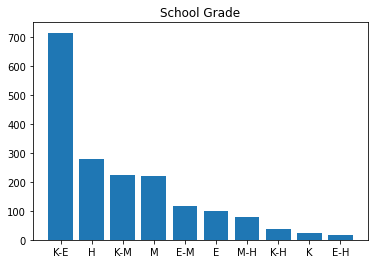

In [73]:
import matplotlib.pyplot as plt

x = range(10)
y = School.Grade.value_counts().values

xlabels = School.Grade.value_counts().index

plt.title("School Grade")
plt.xticks(x, xlabels)
plt.bar(x, y);

In [ ]:
a = Students_percent['% Hispanic'].dropna()
b = Students_percent['% White'].dropna()

In [ ]:
#plt.boxplot(a)
plt.title('% Hispanic')

In [ ]:
#plt.boxplot(b)
plt.title('% White')

In [ ]:
#plt.boxplot(Students_percent.dropna()['% Economically Disadvantaged']);
plt.title('% Economically Disadvantaged')

In [74]:
Students_percent

,School Code,% First Language Not English,% English Language Learner,% Students With Disabilities,% High Needs,% Economically Disadvantaged,% African American,% Asian,% Hispanic,% White,% Native American,"% Native Hawaiian, Pacific Islander","% Multi-Race, Non-Hispanic",% Males,% Females
0,10505,5.3,2.4,9.7,28.8,21.5,2.2,1.5,9.1,85.8,0.2,0.2,0.9,45.6,54.4
1,10003,10.5,7.2,13.3,37.1,23.3,1.9,1.9,6.7,88.4,0.5,0.2,0.3,50.2,49.8
2,10002,12.8,3.0,21.2,34.0,16.3,3.9,3.0,8.4,84.7,0.0,0.0,0.0,54.2,45.8
3,10405,5.5,1.8,13.1,30.8,21.6,2.4,1.8,6.1,89.3,0.0,0.0,0.3,53.4,46.6
4,10015,5.9,2.0,10.8,30.6,22.7,2.0,1.4,4.2,92.1,0.0,0.0,0.3,50.7,49.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,51.2,25.5,11.5,53.4,28.9,35.1,11.5,21.1,29.8,1.2,0.0,1.2,45.0,55.0
1857,35100205,25.8,25.8,4.3,76.7,70.6,24.5,1.8,64.4,6.1,0.0,0.0,3.1,50.9,49.1
1858,39020900,6.2,2.1,20.4,49.9,36.1,6.3,3.3,12.2,70.5,0.4,0.2,7.1,43.4,56.6
1859,35050405,38.3,21.1,19.5,78.0,63.2,56.7,1.6,38.0,1.1,0.4,0.0,2.2,49.2,50.8


In [ ]:
School.describe(include = 'all')

,School Code,School Name,School Type,Town,District Name,Total # of Classes,Average Class Size,Number of Students,TOTAL_Enrollment,Grade
count,1.767000e+03,1767,1767,1767,1767,1767.000000,1767.000000,1767.000000,1767.000000,1767
unique,NaN,1710,2,385,401,NaN,NaN,NaN,NaN,10
top,NaN,Memorial,Public School,Springfield,Boston,NaN,NaN,NaN,NaN,K-E
freq,NaN,6,1691,61,118,NaN,NaN,NaN,NaN,709
mean,2.830570e+06,NaN,NaN,NaN,NaN,247.331070,18.479570,535.173741,529.687040,NaN
std,3.554571e+06,NaN,NaN,NaN,NaN,207.071931,3.862191,356.913288,364.679876,NaN
min,1.000200e+04,NaN,NaN,NaN,NaN,1.000000,2.000000,2.000000,2.000000,NaN
25%,9.600250e+05,NaN,NaN,NaN,NaN,106.000000,16.500000,316.000000,311.000000,NaN
50%,2.100410e+06,NaN,NaN,NaN,NaN,185.000000,18.800000,453.000000,445.000000,NaN
75%,3.300014e+06,NaN,NaN,NaN,NaN,324.000000,20.900000,644.000000,628.000000,NaN


In [102]:
Level[Level.isna()['Accountability and Assistance Level']]

,School Code,Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
476,4450105,NaN,NaN,46.0,69.0,61.0,Level 2,Not meeting gap narrowing goals,69.0,61.0
536,6250415,NaN,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,71.0,61.0
762,3700012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,3700040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,3700026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,3700015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,3700013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,1600515,NaN,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,58.0,57.0
883,1620305,NaN,NaN,NaN,NaN,NaN,Level 2,One or more schools in the district classified...,61.0,56.0
885,1620025,NaN,NaN,NaN,NaN,NaN,Level 2,One or more schools in the district classified...,61.0,56.0


In [103]:
Level[Level.isna()['District_Accountability and Assistance Level']]

,School Code,Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
762,3700012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,3700040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,3700026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,3700015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,3700013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1848,35160305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1849,35140305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850,35170505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,35130305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,35150205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
Level.drop(['Accountability and Assistance Description', 'Progress and Performance Index (PPI) - High Needs Students', 'District_Accountability and Assistance Description', 'District_Progress and Performance Index (PPI) - High Needs Students'], axis = 1, inplace = True)

In [ ]:
# 결측치가 많고 상관관계가 높거나 쓸데없는 컬럼은 미리 빼서 결측치 제거 시 크게 빠져나가지 않게 함

In [105]:
Level

,School Code,Accountability and Assistance Level,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,District_Accountability and Assistance Level,District_Progress and Performance Index (PPI) - All Students
0,10505,Level 1,42.0,76.0,Level 3,63.0
1,10003,Level 3,34.0,69.0,Level 3,63.0
2,10002,Insufficient data,NaN,NaN,Level 3,63.0
3,10405,Level 2,40.0,63.0,Level 3,63.0
4,10015,Level 2,52.0,65.0,Level 3,63.0
...,...,...,...,...,...,...
1856,35060505,Insufficient data,NaN,NaN,Insufficient data,NaN
1857,35100205,Insufficient data,NaN,NaN,Insufficient data,NaN
1858,39020900,Level 3,NaN,NaN,Level 3,NaN
1859,35050405,Level 1,35.0,92.0,Level 1,92.0


In [112]:
Level_sch = Level.iloc[:,:4]
Level_dist = pd.concat([Level.iloc[:,0], Level.drop(Level_sch.columns, axis = 1)], axis = 1)

In [ ]:
                                                                          #School,School_kemh, Students_percent, many_null, test, Level_sch, Level_dist, Salary, MCAS_percent

In [76]:
Salary_main = Salary[['School Code', 'Average Salary', 'Average Expenditures per Pupil']]

In [77]:
test

,School Code,SAT_Tests Taken,Average SAT_Reading,Average SAT_Writing,Average SAT_Math
0,10505,98.0,520.0,498.0,516.0
1,50505,234.0,496.0,475.0,514.0
2,70505,115.0,531.0,518.0,534.0
3,90505,393.0,566.0,562.0,581.0
4,100505,271.0,581.0,576.0,592.0
...,...,...,...,...,...
327,3480285,37.0,435.0,428.0,471.0
328,3480605,209.0,432.0,422.0,437.0
329,39010900,13.0,532.0,505.0,515.0
330,35010505,32.0,413.0,410.0,410.0


In [78]:
test_score = pd.concat([test.iloc[:,0], test.iloc[:, 2:]], axis = 1)

In [ ]:
#test_score

In [ ]:
many_null.describe(include = 'all')

,School Code,# in Cohort,% Graduated,% Still in School,% Non-Grad Completers,% GED,% Dropped Out,% Permanently Excluded,High School Graduates (#),Attending Coll./Univ. (#),% Attending College,% Private Two-Year,% Private Four-Year,% Public Two-Year,% Public Four-Year,% MA Community College,% MA State University,% UMass
count,2.930000e+02,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,3.250916e+06,221.720137,90.662457,3.966212,0.676451,0.719795,3.932765,0.044710,202.447099,157.938567,78.021160,0.125939,34.483959,27.629693,37.765870,26.495904,13.713311,14.305802
std,2.579629e+06,136.550019,8.639569,4.298389,1.383473,0.876648,4.597075,0.211682,122.120511,98.665737,11.374314,0.397091,13.331340,17.061989,10.504911,16.763228,7.696685,6.467368
min,1.050500e+04,23.000000,53.900000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,14.000000,40.700000,0.000000,7.100000,0.000000,7.400000,0.000000,0.000000,0.000000
25%,1.220505e+06,112.000000,87.700000,1.200000,0.000000,0.000000,0.900000,0.000000,101.000000,76.000000,71.400000,0.000000,25.400000,14.400000,30.100000,13.400000,7.800000,10.000000
50%,2.460505e+06,200.000000,93.300000,2.700000,0.000000,0.500000,2.600000,0.000000,183.000000,144.000000,80.400000,0.000000,33.000000,24.500000,38.800000,24.000000,12.800000,14.400000
75%,4.940205e+06,307.000000,96.400000,5.100000,0.900000,1.000000,5.300000,0.000000,280.000000,217.000000,87.300000,0.000000,42.400000,39.000000,45.800000,37.300000,18.500000,17.900000
max,8.780605e+06,1013.000000,100.000000,32.800000,14.900000,4.800000,28.300000,1.900000,897.000000,682.000000,95.200000,3.600000,77.800000,77.800000,67.900000,76.000000,50.000000,37.900000


In [ ]:
many_null.columns

Index(['School Code', '# in Cohort', '% Graduated', '% Still in School',
       '% Non-Grad Completers', '% GED', '% Dropped Out',
       '% Permanently Excluded', 'High School Graduates (#)',
       'Attending Coll./Univ. (#)', '% Attending College',
       '% Private Two-Year', '% Private Four-Year', '% Public Two-Year',
       '% Public Four-Year', '% MA Community College', '% MA State University',
       '% UMass'],
      dtype='object')

In [113]:
Level_sch

,School Code,Accountability and Assistance Level,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students
0,10505,Level 1,42.0,76.0
1,10003,Level 3,34.0,69.0
2,10002,Insufficient data,NaN,NaN
3,10405,Level 2,40.0,63.0
4,10015,Level 2,52.0,65.0
...,...,...,...,...
1856,35060505,Insufficient data,NaN,NaN
1857,35100205,Insufficient data,NaN,NaN
1858,39020900,Level 3,NaN,NaN
1859,35050405,Level 1,35.0,92.0


In [115]:
Level_sch.dropna(subset = ['Accountability and Assistance Level'], inplace = True)
Level_sch = Level_sch[Level_sch['Accountability and Assistance Level'] != 'Insufficient data']
Level_sch.columns = ['School Code', 'Level', 'SA Percent', 'PPI-All']

In [ ]:
#Level_sch

In [119]:
Level_dist = Level_dist.dropna(subset = ['District_Accountability and Assistance Level'])
Level_dist = Level_dist[Level_dist['District_Accountability and Assistance Level'] != 'Insufficient data']
Level_dist.columns = ['School Code', 'Dist Level', 'Dist PPI-All']

In [120]:
Level_s1 = Level_sch[Level_sch['Level'] == 'Level 1']
Level_s2 = Level_sch[Level_sch['Level'] == 'Level 2']
Level_s3 = Level_sch[Level_sch['Level'] == 'Level 3']
Level_s4 = Level_sch[Level_sch['Level'] == 'Level 4']
Level_s5 = Level_sch[Level_sch['Level'] == 'Level 5']

In [121]:
Level_d1 = Level_dist[Level_dist['Dist Level'] == 'Level 1']
Level_d2 = Level_dist[Level_dist['Dist Level'] == 'Level 2']
Level_d3 = Level_dist[Level_dist['Dist Level'] == 'Level 3']
Level_d4 = Level_dist[Level_dist['Dist Level'] == 'Level 4']
Level_d5 = Level_dist[Level_dist['Dist Level'] == 'Level 5']

In [128]:
[x for x in Level.columns if ('Level' in x) or ('PPI' in x)]

['Accountability and Assistance Level',
 'Progress and Performance Index (PPI) - All Students',
 'District_Accountability and Assistance Level',
 'District_Progress and Performance Index (PPI) - All Students']

In [131]:
li = [x for x in Level.columns if ('Level' in x) or ('PPI' in x)]
Level_DS = Level[li]

In [132]:
group1 = Level_DS.groupby('Accountability and Assistance Level', as_index = False)['District_Progress and Performance Index (PPI) - All Students'].mean()
group2 = Level_DS.groupby('District_Accountability and Assistance Level', as_index = False)['Progress and Performance Index (PPI) - All Students'].mean()

In [133]:
import seaborn as sns

In [ ]:
sns.stripplot(x=Level_sch["Level"].sort_values(), y="PPI-All", data=Level_sch, jitter=True)

plt.axhline(Level_s1['PPI-All'].mean())
plt.axhline(Level_s2['PPI-All'].mean(), color='orange')
plt.axhline(Level_s3['PPI-All'].mean(), color='green')
plt.axhline(Level_s4['PPI-All'].mean(), color='red')

plt.title("Relation between Level and PPI-All");

In [ ]:
sns.stripplot(x=Level_dist["Dist Level"].sort_values(), y="Dist PPI-All", data=Level_dist, jitter=True)

plt.axhline(Level_d1['Dist PPI-All'].mean())
plt.axhline(Level_d2['Dist PPI-All'].mean(), color='orange')
plt.axhline(Level_d3['Dist PPI-All'].mean(), color='green')
plt.axhline(Level_d4['Dist PPI-All'].mean(), color='red')
plt.axhline(Level_d5['Dist PPI-All'].mean(), color='purple')

plt.title("Relation between Dist Level and Dist PPI-All");

In [ ]:
Students_percent

,School Code,% First Language Not English,% English Language Learner,% Students With Disabilities,% High Needs,% Economically Disadvantaged,% African American,% Asian,% Hispanic,% White,% Native American,"% Native Hawaiian, Pacific Islander","% Multi-Race, Non-Hispanic",% Males,% Females
0,10505,5.3,2.4,9.7,28.8,21.5,2.2,1.5,9.1,85.8,0.2,0.2,0.9,45.6,54.4
1,10003,10.5,7.2,13.3,37.1,23.3,1.9,1.9,6.7,88.4,0.5,0.2,0.3,50.2,49.8
2,10002,12.8,3.0,21.2,34.0,16.3,3.9,3.0,8.4,84.7,0.0,0.0,0.0,54.2,45.8
3,10405,5.5,1.8,13.1,30.8,21.6,2.4,1.8,6.1,89.3,0.0,0.0,0.3,53.4,46.6
4,10015,5.9,2.0,10.8,30.6,22.7,2.0,1.4,4.2,92.1,0.0,0.0,0.3,50.7,49.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,51.2,25.5,11.5,53.4,28.9,35.1,11.5,21.1,29.8,1.2,0.0,1.2,45.0,55.0
1857,35100205,25.8,25.8,4.3,76.7,70.6,24.5,1.8,64.4,6.1,0.0,0.0,3.1,50.9,49.1
1858,39020900,6.2,2.1,20.4,49.9,36.1,6.3,3.3,12.2,70.5,0.4,0.2,7.1,43.4,56.6
1859,35050405,38.3,21.1,19.5,78.0,63.2,56.7,1.6,38.0,1.1,0.4,0.0,2.2,49.2,50.8


In [137]:
School_anal = School[['School Code', 'School Type', 'Total # of Classes', 'Average Class Size', 'Number of Students', 'Grade']] #,School_kemh

In [138]:
School_anal

,School Code,School Type,Total # of Classes,Average Class Size,Number of Students,Grade
0,10505,Public School,204.0,15.8,451.0,H
1,10003,Public School,325.0,24.6,643.0,E
2,10002,Public School,112.0,14.6,208.0,K
3,10405,Public School,218.0,21.1,342.0,M
4,10015,Public School,121.0,30.4,334.0,E-M
...,...,...,...,...,...,...
1800,35060505,Charter School,124.0,18.8,267.0,M-H
1801,35100205,Charter School,20.0,27.0,108.0,K-E
1802,39020900,Public School,383.0,25.7,1014.0,K-H
1803,35050405,Charter School,192.0,21.9,655.0,K-M


In [160]:
ML = pd.merge(School_anal, Students_percent, on = 'School Code', how = 'outer')

In [161]:
ML = pd.merge(ML, Salary_main, on = 'School Code', how = 'outer')

In [165]:
ML = pd.merge(ML, Level_sch, on = 'School Code', how = 'inner')

In [167]:
ML_all = pd.merge(ML, Level_dist, on = 'School Code', how = 'inner')

In [ ]:
ML_all#.info()

In [ ]:
#ML_all = ML_all.dropna().reset_index(drop = True)

In [145]:
group1 = Level_DS.groupby('Accountability and Assistance Level', as_index = False)['District_Progress and Performance Index (PPI) - All Students'].mean()
group2 = Level_DS.groupby('District_Accountability and Assistance Level', as_index = False)['Progress and Performance Index (PPI) - All Students'].mean()

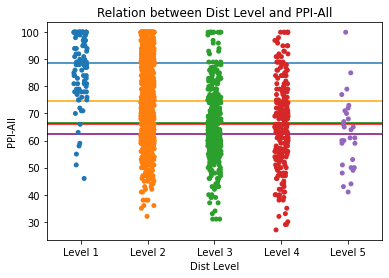

In [146]:
sns.stripplot(x=ML_all["Dist Level"].sort_values(), y="PPI-All", data=ML_all, jitter=True)

plt.axhline(group2.iloc[1][1])
plt.axhline(group2.iloc[2][1], color='orange')
plt.axhline(group2.iloc[3][1], color='green')
plt.axhline(group2.iloc[4][1], color='red')
plt.axhline(group2.iloc[5][1], color='purple')

plt.title("Relation between Dist Level and PPI-All");

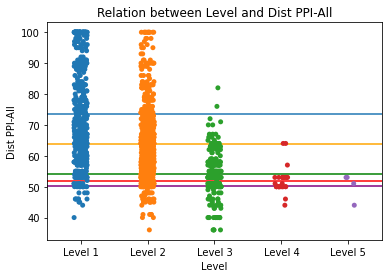

In [147]:
sns.stripplot(x=ML_all["Level"].sort_values(), y="Dist PPI-All", data=ML_all, jitter=True)
plt.axhline(group1.iloc[1][1])
plt.axhline(group1.iloc[2][1], color='orange')
plt.axhline(group1.iloc[3][1], color='green')
plt.axhline(group1.iloc[4][1], color='red')
plt.axhline(group1.iloc[5][1], color='purple')
plt.title("Relation between Level and Dist PPI-All");


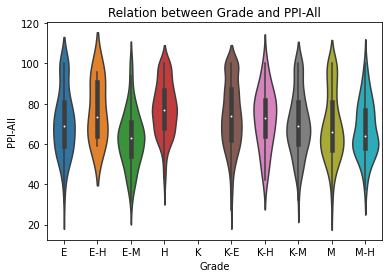

In [150]:
sns.violinplot(x=ML_all["Grade"].sort_values(), y="PPI-All", data=ML_all)
plt.title("Relation between Grade and PPI-All")
plt.show();

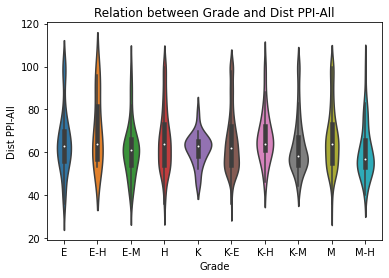

In [149]:
sns.violinplot(x=ML_all["Grade"].sort_values(), y="Dist PPI-All", data=ML_all)
plt.title("Relation between Grade and Dist PPI-All")
plt.show();

In [ ]:
ML_all.corr()

In [ ]:
corr = ML_all.corr()

PPI_All_corr = ML_all.corr().iloc[:,-2].sort_values(ascending = False)

plt.figure(figsize=(10, 10))

y = range(len(PPI_All_corr))
values = PPI_All_corr.values
ylables = PPI_All_corr.index

#plt.barh(y, values)
plt.yticks(y, ylables);

In [184]:
ML_all.corr().iloc[:,-1].sort_values(ascending = False)

Dist PPI-All                           1.000000
SA Percent                             0.714879
PPI-All                                0.627855
% Asian                                0.352152
Average Salary                         0.270688
% White                                0.264703
School Code                            0.131881
% Females                              0.117351
Number of Students                     0.094062
Average Expenditures per Pupil         0.087465
Total # of Classes                     0.080447
% Multi-Race, Non-Hispanic             0.072803
Average Class Size                     0.064719
% Native Hawaiian, Pacific Islander   -0.047257
% Native American                     -0.059384
% Males                               -0.117564
% Students With Disabilities          -0.199762
% African American                    -0.210696
% First Language Not English          -0.221083
% English Language Learner            -0.287504
% Hispanic                            -0

In [ ]:
Dist_PPI_All_corr = ML_all.corr().iloc[:,-1].sort_values(ascending = False)

plt.figure(figsize=(10, 10))

y = range(len(Dist_PPI_All_corr))
values = Dist_PPI_All_corr.values
ylables = Dist_PPI_All_corr.index

#plt.barh(y, values)
plt.yticks(y, ylables);

In [ ]:
ML_all.corr().iloc[:,8].sort_values(ascending = False)

Econo_disadv_corr = ML_all.corr().iloc[:,8].sort_values(ascending = False)

plt.figure(figsize=(10, 10))

y = range(len(Econo_disadv_corr))
values = Econo_disadv_corr.values
ylables = Econo_disadv_corr.index

#plt.barh(y, values)
plt.yticks(y, ylables);

In [156]:
def Relation(corr, Pos, Neg):
  if Neg == 1:
    Neg = corr < -0.6
    for i in range(len(Neg)):
      logic = Neg.iloc[:,i]
      Tr = logic[logic == True]
      print(Tr)
      print('\n\n')
  elif Pos == 1:
    Pos = corr > 0.6
    for i in range(len(Pos)):
      logic = Pos.iloc[:,i]
      Tr = logic[logic == True]
      print(Tr)
      print('\n\n')

In [ ]:
#Relation(corr, 0, 1)

In [185]:
ML_PPI = ML_all[['SA Percent', '% Asian', '% Hispanic', "Dist Level", '% Economically Disadvantaged', 'Level', 'PPI-All']]
ML_Dist_PPI = ML_all[['SA Percent', '% Asian', '% Hispanic', 'Dist Level', 'Level', '% Economically Disadvantaged', 'Dist PPI-All']]
ML_Econo_Disadv = ML_all[['% English Language Learner', '% Hispanic', '% White', 'SA Percent', '% Economically Disadvantaged']]

In [186]:
ML_PPI.dropna(subset = ['PPI-All'], inplace = True)
ML_Dist_PPI.dropna(subset = ['Dist PPI-All'], inplace = True)
ML_Econo_Disadv.dropna(subset = ['% Economically Disadvantaged'], inplace = True)

In [ ]:
#sns.pairplot(ML_PPI)
plt.title("ML_PPI Plot")
plt.show()

In [ ]:
#sns.pairplot(ML_Dist_PPI)
plt.title("summary")
plt.show()

In [ ]:
#sns.pairplot(ML_Econo_Disadv)
plt.title("summary")
plt.show()

In [ ]:
a = ML_PPI['PPI-All']
sns.distplot(a)
a.skew()

In [ ]:
a = pd.Series(stats.boxcox(ML_PPI['PPI-All'])[0])
sns.distplot(a)
a.skew()

In [ ]:
a = ML_Dist_PPI['Dist PPI-All']
sns.displot(a)
a.skew()

In [ ]:
a = pd.Series(stats.boxcox(ML_Dist_PPI['Dist PPI-All'])[0])
sns.distplot(a)
a.skew()

In [ ]:
a = ML_Econo_Disadv['% Economically Disadvantaged']
sns.distplot(a)
a.skew()

In [ ]:
a = pd.Series(stats.boxcox(ML_Econo_Disadv['% Economically Disadvantaged'])[0])
sns.distplot(a)
a.skew()

In [247]:
def split(df, features, target):
  X = df[features]
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  


  return X_train, X_test, y_train, y_test

In [442]:
features = ML_PPI.columns.drop(['PPI-All'])
target = 'PPI-All'

X_train, X_test, y_train, y_test = split(ML_PPI, features, target)

In [443]:
X_train.shape, X_test.shape

((1269, 6), (318, 6))

In [196]:
from scipy import stats

In [267]:
y = ML_PPI['PPI-All']
base_PPI = y.mean()
base_PPI = len(y) * [base_PPI]
mean_absolute_error(y, base_PPI)

13.309325255730537

In [193]:
map_level = {'Level 1' : 1, 'Level 2': 2, 'Level 3': 3, 'Level 4': 4, 'Level 5': 5}

In [436]:
pipe = make_pipeline(
    OrdinalEncoder(cols = ['Level', 'Dist Level'], mapping = [{'col': 'Level', 'mapping': map_level}, {'col': 'Dist Level', 'mapping': map_level}]),
    SimpleImputer(),
    XGBRegressor(objective = 'reg:squarederror')
)

In [437]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

dists = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': randint(5, 15),
    'xgbregressor__learning_rate': uniform(0, 1),
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [270]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbregressor__learning_rate': 0.041150654813248644, 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 161}
MAE:  7.985341982168886


In [438]:
regressor = clf.best_estimator_
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트세트 MAE: {mae}')

테스트세트 MAE: 7.94113064412051


In [297]:
regressor

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Level', 'Dist Level'],
                                mapping=[{'col': 'Level',
                                          'mapping': {'Level 1': 1,
                                                      'Level 2': 2,
                                                      'Level 3': 3,
                                                      'Level 4': 4,
                                                      'Level 5': 5}},
                                         {'col': 'Dist Level',
                                          'mapping': {'Level 1': 1,
                                                      'Level 2': 2,
                                                      'Level 3': 3,
                                                      'Level 4': 4,
                                                      'Level 5': 5}}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbregre

In [439]:
imputer = regressor.named_steps['simpleimputer']
encoder = regressor.named_steps['ordinalencoder']

preprocess = make_pipeline(
    encoder,
    imputer
)

In [300]:
def reg_permut_show(X_test, y_test, regressor, preprocess):

  permuter = PermutationImportance(
    regressor.named_steps['xgbregressor'],
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=2
)
  X_test_transformed = preprocess.transform(X_test)

  permuter.fit(X_test_transformed, y_test);

  feature_names = X_test.columns.tolist()
  
  a = eli5.show_weights(
      permuter, 
      top=None,
      feature_names=feature_names
      )

  return a

In [329]:
reg_permut_show(X_test, y_test, regressor, preprocess)

Weight,Feature
4.7955 ± 0.7237,SA Percent
2.4418 ± 0.6007,Level
0.8100 ± 0.3842,% Economically Disadvantaged
0.3698 ± 0.2527,% Hispanic
0.0700 ± 0.0510,% Asian
0.0100 ± 0.0221,Dist Level


In [355]:
preprocess

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Level', 'Dist Level'],
                                mapping=[{'col': 'Level',
                                          'mapping': {'Level 1': 1,
                                                      'Level 2': 2,
                                                      'Level 3': 3,
                                                      'Level 4': 4,
                                                      'Level 5': 5}},
                                         {'col': 'Dist Level',
                                          'mapping': {'Level 1': 1,
                                                      'Level 2': 2,
                                                      'Level 3': 3,
                                                      'Level 4': 4,
                                                      'Level 5': 5}}])),
                ('simpleimputer', SimpleImputer(strategy='median'))])

In [361]:
def pdp(df, features, target, preprocess):
  X = df[features]
  y = df[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  X_train_encoded = preprocess.transform(X_train)
  X_test_encoded = preprocess.transform(X_test)

  regressor = RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
  regressor.fit(X_train_encoded, y_train)
  
  for i in X.columns:
    feature = i

    isolated = pdp_isolate(
        model=regressor, 
        dataset=pd.DataFrame(X_test_encoded, columns = X_train.columns), 
        model_features=X_test.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=50 # default=10
        )
    a = pdp_plot(isolated, feature_name=feature);
    display(a)


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d687b80>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d51ec40>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60cae370>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d64a6a0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c607c27c0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c607c2940>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c608286a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60ed60d0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5ccf25e0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5ccf2d90>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5e4abb20>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d995070>})

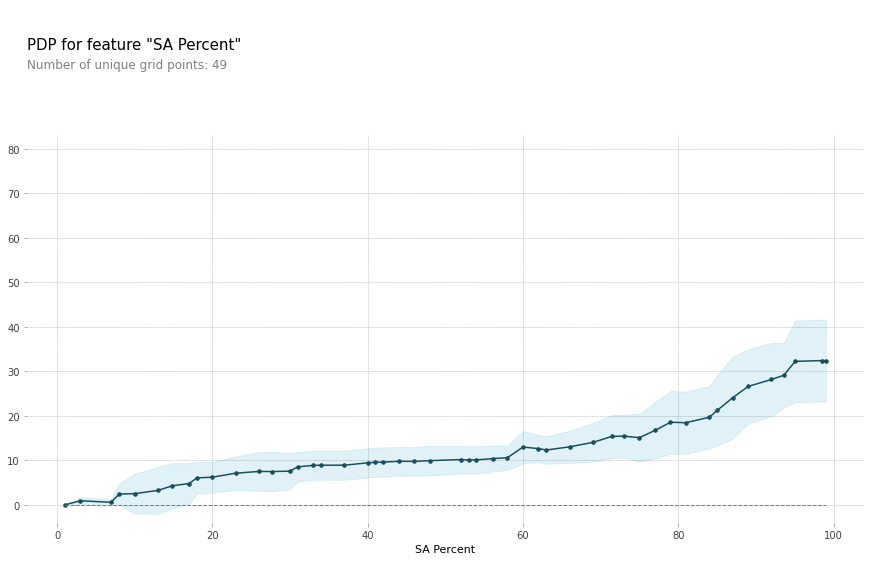

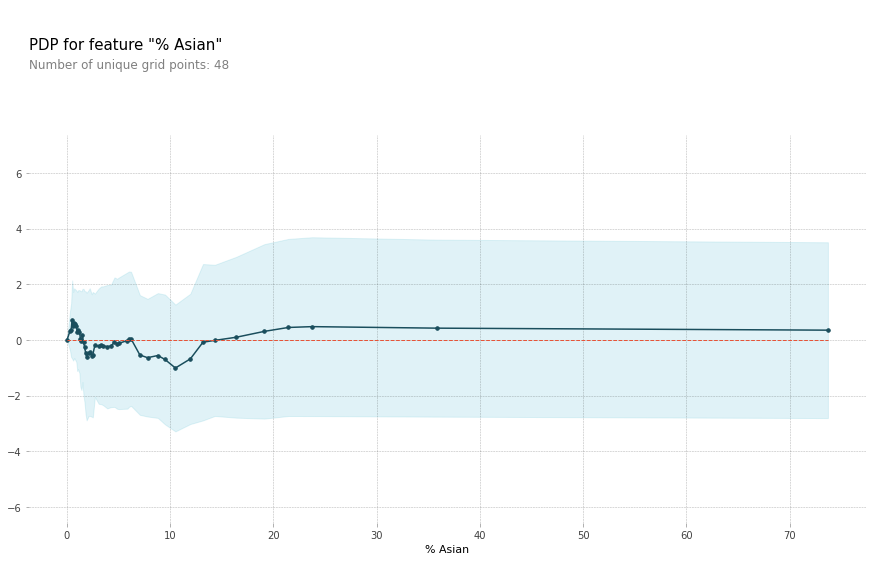

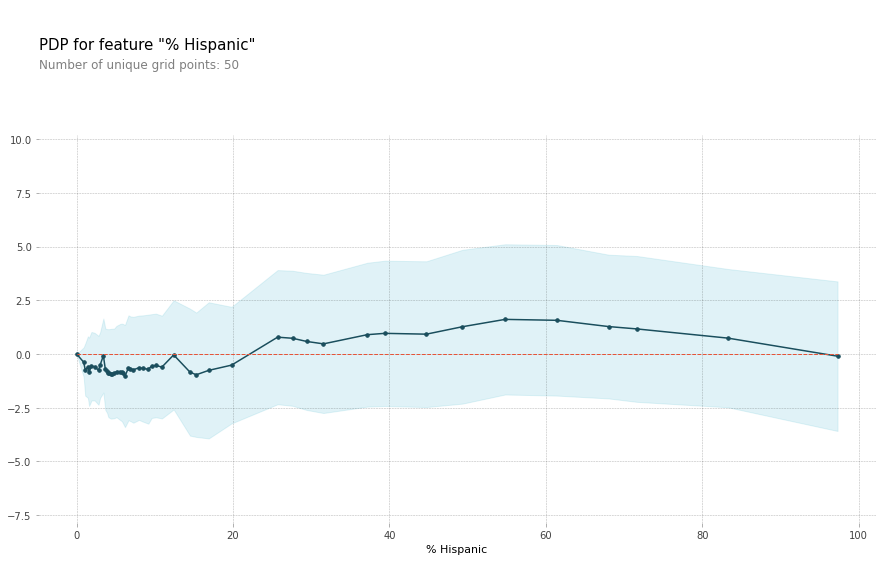

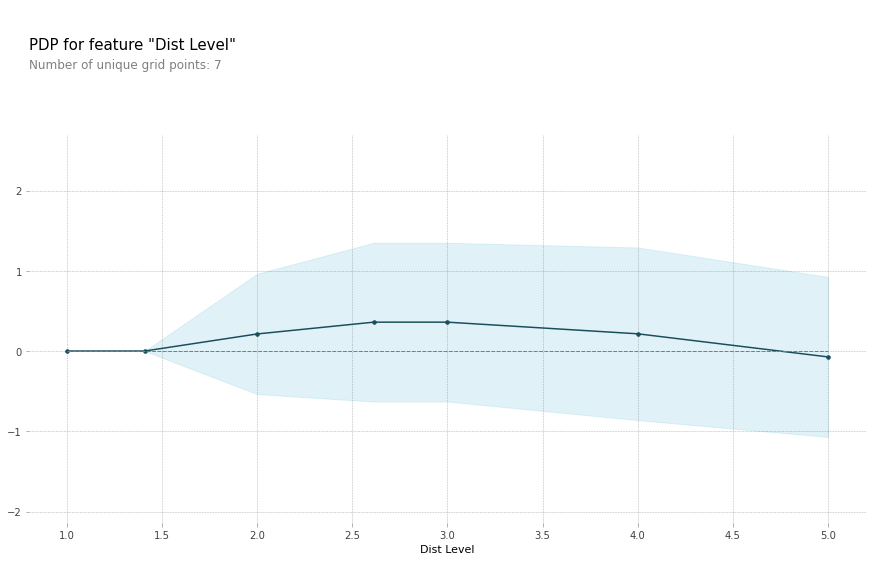

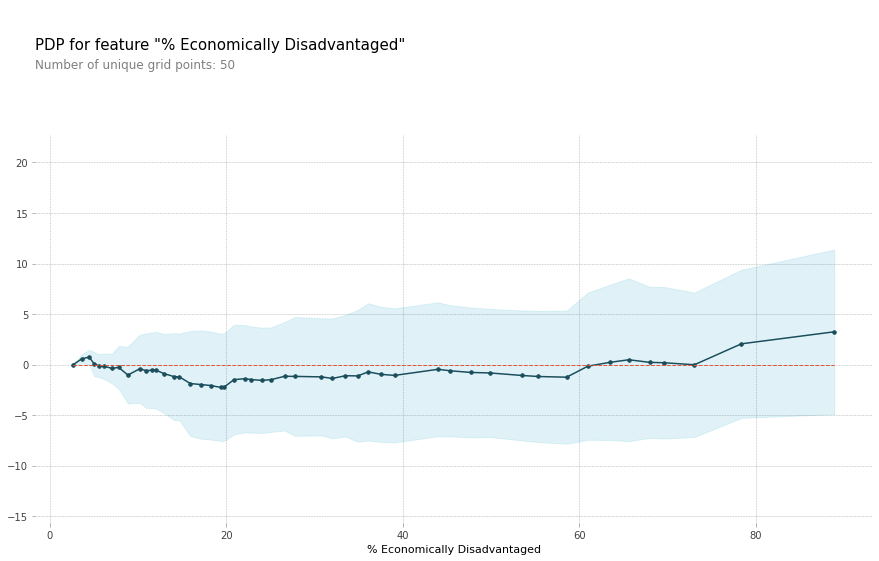

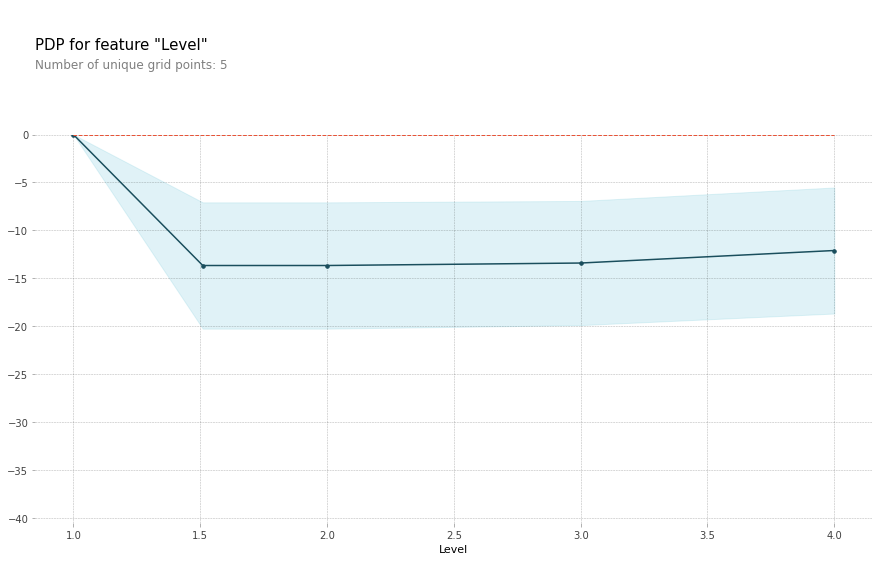

In [440]:
features = ML_PPI.columns.drop(['PPI-All'])
target = 'PPI-All'
pdp(ML_PPI, features, target, preprocess)

In [370]:
def reg_shap(df, features, target):
  X = df[features]
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  X_train_encoded = preprocess.transform(X_train)
  X_test_encoded = pd.DataFrame(preprocess.transform(X_test), columns = X_test.columns)

  regressor = RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
  regressor.fit(X_train_encoded, y_train)

  shap.initjs()

  feature_names = X_test.columns.tolist()
  explainer = shap.TreeExplainer(regressor)
  
  shap_values = explainer.shap_values(X_test_encoded)
  shap.summary_plot(shap_values, X_test_encoded)

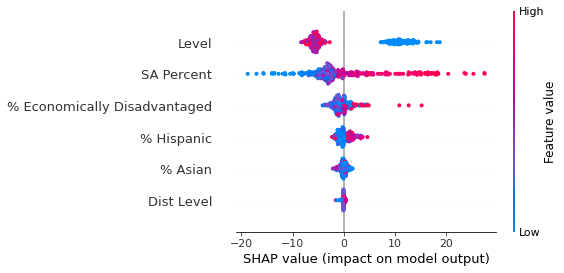

In [371]:
reg_shap(ML_PPI, features, target)

In [444]:
features = ML_Dist_PPI.columns.drop(['Dist PPI-All'])
target = 'Dist PPI-All'

X_train, X_test, y_train, y_test = split(ML_Dist_PPI, features, target)

In [446]:
X_train.shape, X_test.shape

((1280, 6), (321, 6))

In [217]:
y = ML_Dist_PPI['Dist PPI-All']
base_PPI = y.mean()
base_PPI = len(y) * [base_PPI]
mean_absolute_error(y, base_PPI)

11.223545090689337

In [373]:
pipe = make_pipeline(
    OrdinalEncoder(cols = ['Level', 'Dist Level'], mapping = [{'col': 'Level', 'mapping': map_level}, {'col': 'Dist Level', 'mapping': map_level}]),
    SimpleImputer(),
    XGBRegressor(objective = 'reg:squarederror')
)

In [374]:
dists = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': randint(5, 15),
    'xgbregressor__learning_rate': uniform(0, 1),
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [375]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'xgbregressor__learning_rate': 0.023591142411674704, 'xgbregressor__max_depth': 11, 'xgbregressor__n_estimators': 324}
MAE:  5.920636967644537


In [377]:
regressor = clf.best_estimator_
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트세트 MAE: {mae}')

테스트세트 MAE: 5.652542470771576


In [378]:
imputer = regressor.named_steps['simpleimputer']
encoder = regressor.named_steps['ordinalencoder']

preprocess = make_pipeline(
    encoder,
    imputer
)

In [380]:
reg_permut_show(X_test, y_test, regressor, preprocess)

Weight,Feature
2.7013 ± 0.2426,Dist Level
2.0179 ± 0.6794,% Economically Disadvantaged
1.9658 ± 0.5558,SA Percent
1.3840 ± 0.5181,% Hispanic
0.6989 ± 0.2607,% Asian
0.0637 ± 0.0935,Level


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cd95c70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cf98b50>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cd3a9a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cd0f070>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cce1b20>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d8e98b0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d89bf70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d80ac40>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d7f1a90>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d786df0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d773580>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cd3a250>})

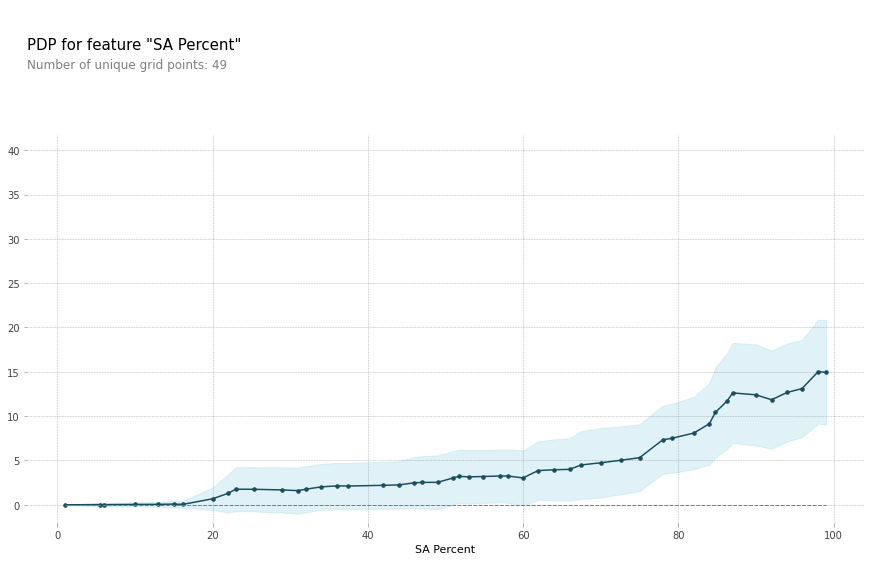

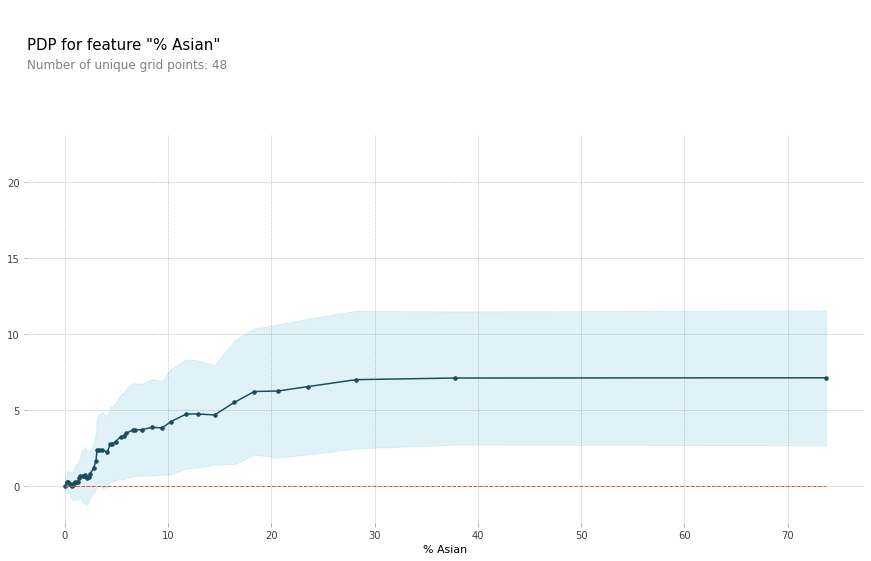

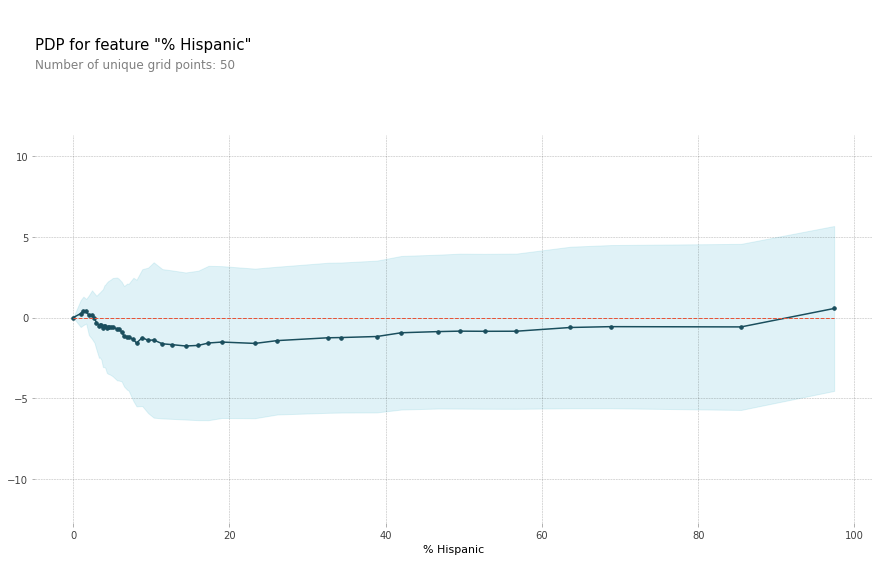

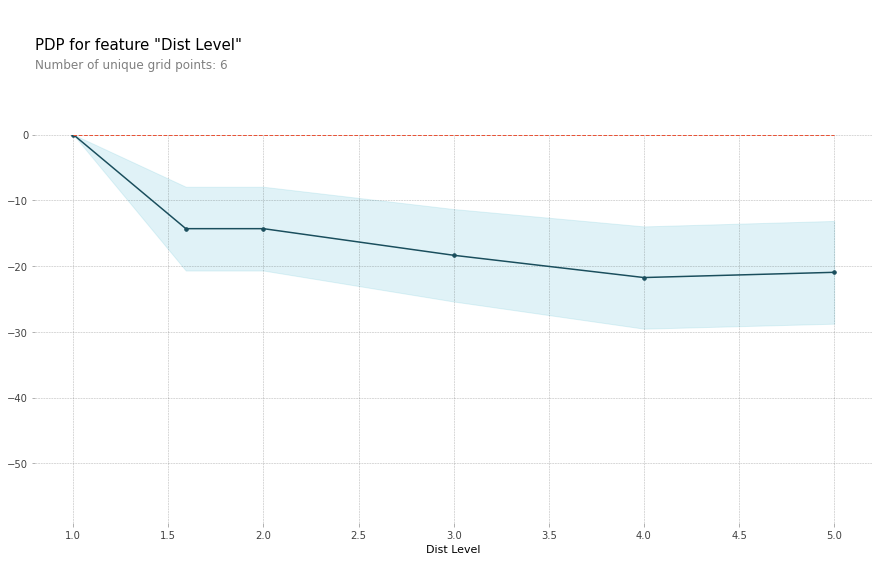

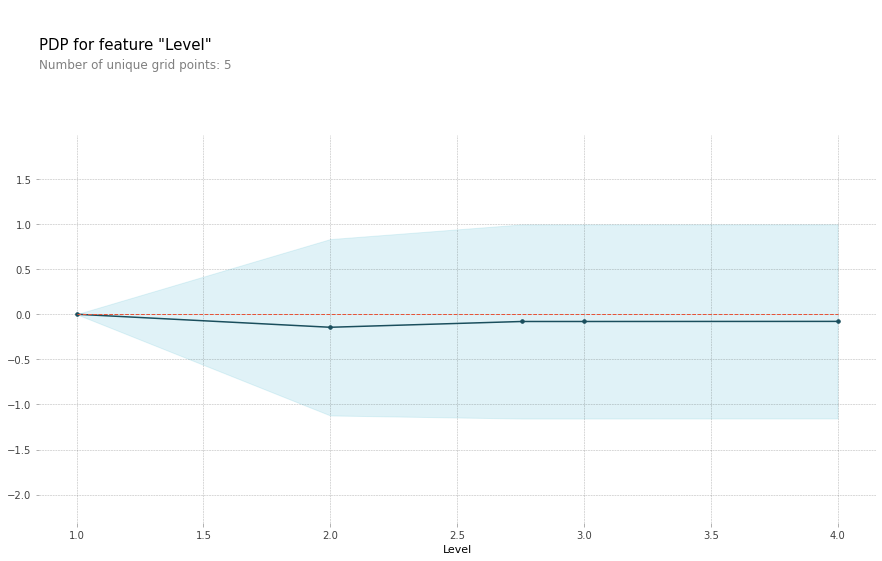

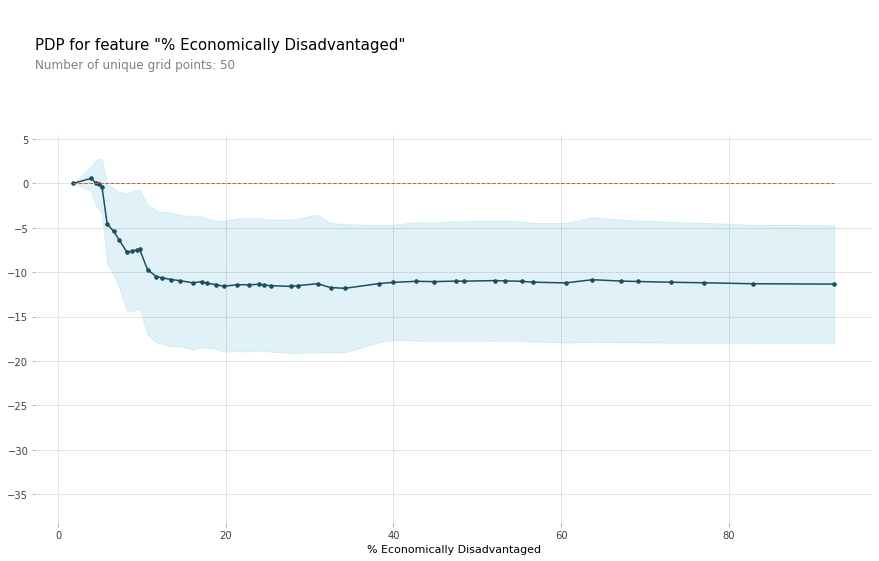

In [382]:
features = ML_Dist_PPI.columns.drop(['Dist PPI-All'])
target = 'Dist PPI-All'
pdp(ML_Dist_PPI, features, target, preprocess)

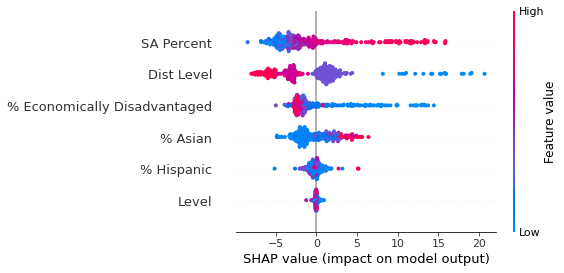

In [383]:
reg_shap(ML_Dist_PPI, features, target)

In [447]:
features = ML_Econo_Disadv.columns.drop(['% Economically Disadvantaged'])
target = '% Economically Disadvantaged'

X_train, X_test, y_train, y_test = split(ML_Econo_Disadv, features, target)

y_train = stats.boxcox(y_train)[0]
y_test = stats.boxcox(y_test)[0]

In [448]:
X_train.shape, X_test.shape

((1283, 4), (321, 4))

In [385]:
Econo_Disadv_y_base = stats.boxcox(ML_Econo_Disadv['% Economically Disadvantaged'])[0]
base_PPI = Econo_Disadv_y_base.mean()
base_PPI = len(Econo_Disadv_y_base) * [base_PPI]
mean_absolute_error(Econo_Disadv_y_base, base_PPI)

1.74101041398441

In [386]:
pipe = make_pipeline(
    SimpleImputer(),
    XGBRegressor(objective = 'reg:squarederror')
)

In [387]:
dists = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': randint(5, 15),
    'xgbregressor__learning_rate': uniform(0, 1),
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [388]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbregressor__learning_rate': 0.12788196310586541, 'xgbregressor__max_depth': 9, 'xgbregressor__n_estimators': 58}
MAE:  0.7316338850046794


In [389]:
regressor = clf.best_estimator_
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트세트 MAE: {mae}')

테스트세트 MAE: 0.7309383124160146


In [392]:
preprocess = regressor.named_steps['simpleimputer']

reg_permut_show(X_test, y_test, regressor, preprocess)

Weight,Feature
0.5676 ± 0.0578,SA Percent
0.4292 ± 0.0819,% Hispanic
0.0988 ± 0.0244,% White
0.0638 ± 0.0245,% English Language Learner


In [395]:
ML_Econo_Disadv

,% English Language Learner,% Hispanic,% White,SA Percent,% Economically Disadvantaged
0,2.4,9.1,85.8,42.0,21.5
1,7.2,6.7,88.4,34.0,23.3
2,1.8,6.1,89.3,40.0,21.6
3,2.0,4.2,92.1,52.0,22.7
4,0.4,3.3,92.8,65.0,25.3
...,...,...,...,...,...
1599,2.2,4.6,87.0,NaN,9.1
1600,13.6,48.6,32.7,24.0,62.6
1601,1.0,16.8,64.3,7.0,47.8
1602,2.1,12.2,70.5,NaN,36.1


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d733c70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d71b370>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d569b50>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cccc0d0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5d64ed60>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cd6f370>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5cf1da60>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5ce52ee0>})

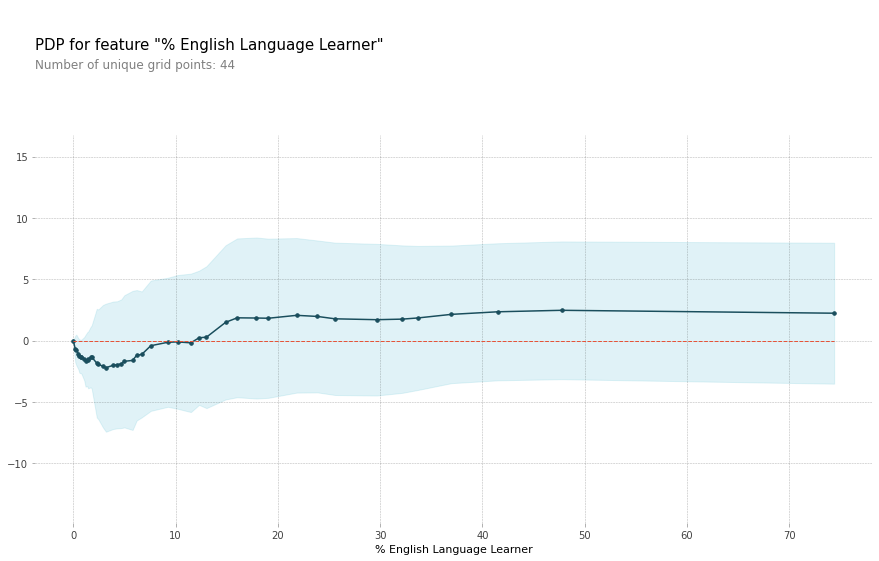

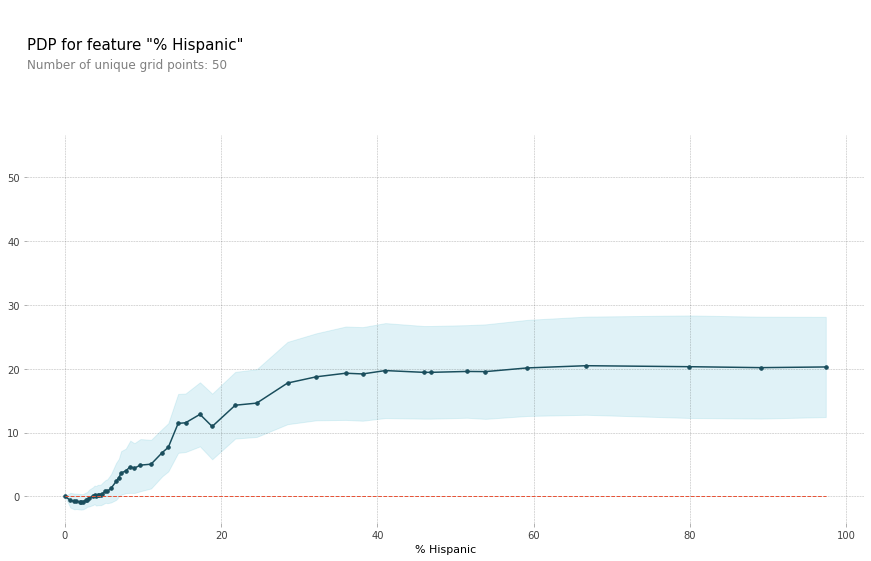

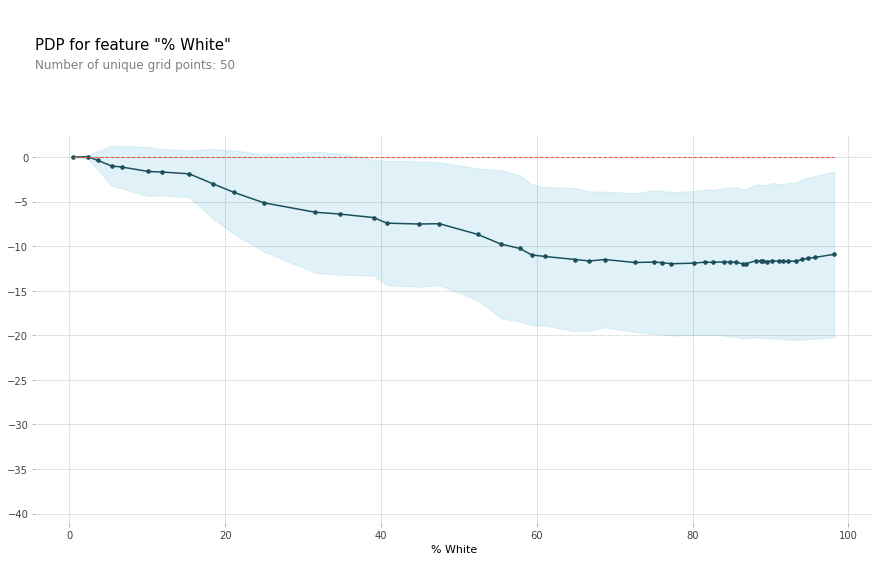

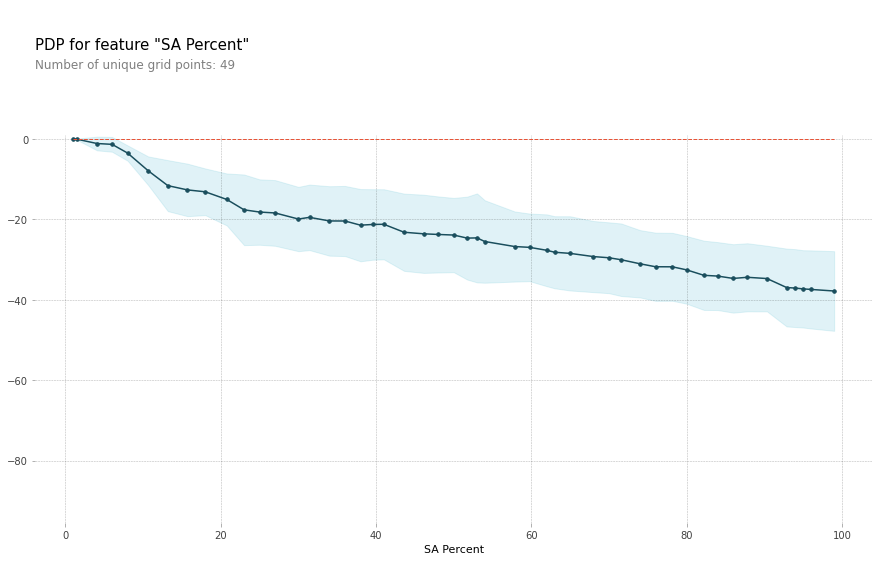

In [394]:
features = ML_Econo_Disadv.columns.drop(['% Economically Disadvantaged'])
target = '% Economically Disadvantaged'
pdp(ML_Econo_Disadv, features, target, preprocess)

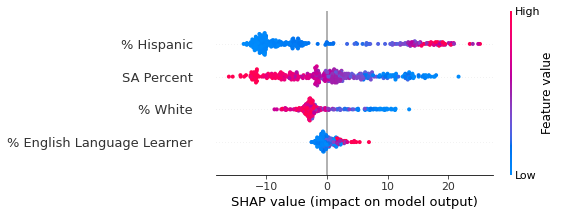

In [397]:
reg_shap(ML_Econo_Disadv, features, target)

In [228]:
test_score

,School Code,Average SAT_Reading,Average SAT_Writing,Average SAT_Math
0,10505,520.0,498.0,516.0
1,50505,496.0,475.0,514.0
2,70505,531.0,518.0,534.0
3,90505,566.0,562.0,581.0
4,100505,581.0,576.0,592.0
...,...,...,...,...
327,3480285,435.0,428.0,471.0
328,3480605,432.0,422.0,437.0
329,39010900,532.0,505.0,515.0
330,35010505,413.0,410.0,410.0


In [229]:
more = ML_all.drop(['Grade'], axis = 1) #Grade 모두 H이므로 drop

In [230]:
more = more.iloc[:, 5:]

In [ ]:
more

In [231]:
more = pd.concat([ML_all['School Code'], more], axis = 1)

In [232]:
School.drop(['School Name', 'Grade', 'TOTAL_Enrollment'], axis = 1, inplace = True)

In [ ]:
#School

In [233]:
Score_anal = School.merge(test_score, on = 'School Code', how = 'inner') #지역과 성적 상관관계 분석

In [ ]:
#Score_anal

In [234]:
Score_anal = more.merge(Score_anal, on = 'School Code', how = 'inner')

In [ ]:
Score_anal#.columns

In [236]:
data = Score_anal.iloc[:,-3:]

In [237]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [238]:
scaled = pd.DataFrame(data, columns = ['Scaled_sat_reading', 'Scaled_sat_writing', 'Scaled_sat_math'])

In [239]:
Score_anal['SAT Scale and Sum'] = scaled.apply(lambda x: 100*sum(x), axis = 1)

In [ ]:
#Score_anal

In [241]:
Score_anal = Score_anal.drop(['% Economically Disadvantaged', 'Average SAT_Reading', 'Average SAT_Writing', 'Average SAT_Math'], axis = 1) #상관관계 높은 컬럼 drop

In [ ]:
#Score_anal

In [ ]:
corr = Score_anal.corr()

In [ ]:
#corr

In [ ]:
#Relation(corr, 1, 0)

NameError: ignored

In [ ]:
Score_anal_corr = Score_anal.corr().iloc[:,-1].sort_values(ascending = False)

plt.figure(figsize=(10, 10))

y = range(len(Score_anal_corr))
values = Score_anal_corr.values
ylables = Score_anal_corr.index

plt.barh(y, values)
plt.yticks(y, ylables);

In [ ]:
Score_anal.corr().iloc[:,-1].sort_values(ascending = False)

In [ ]:
Score_anal#.index

,% English Language Learner,% Hispanic,% High Needs,SA Percent,% White,Dist PPI-All,Town,District Name,SAT Scale and Sum
0,2.4,9.1,28.8,42.0,85.8,63.0,Abington,Abington,183.515139
1,1.3,5.8,32.0,41.0,88.8,54.0,Agawam,Agawam,167.323712
2,0.5,4.2,25.9,53.0,90.7,50.0,Amesbury,Amesbury,199.500131
3,0.8,5.0,20.9,81.0,76.3,83.0,Andover,Andover,240.682897
4,0.9,5.7,20.7,73.0,75.6,76.0,Arlington,Arlington,253.815834
...,...,...,...,...,...,...,...,...,...
263,22.8,31.7,58.9,19.0,40.6,57.0,Worcester,Worcester,141.106943
264,32.4,47.9,81.4,3.0,21.0,57.0,Worcester,Worcester,71.692967
265,31.5,43.7,75.9,23.0,23.9,57.0,Worcester,Worcester,121.324174
266,25.6,53.5,68.5,54.0,11.8,57.0,Worcester,Worcester,117.698884


In [ ]:
Score_anal_corr

SAT Scale and Sum             1.000000
SA Percent                    0.758363
% White                       0.656911
Dist PPI-All                  0.494101
% English Language Learner   -0.665865
% Hispanic                   -0.685784
% High Needs                 -0.872592
Name: SAT Scale and Sum, dtype: float64

SAT Scale and Sum             1.000000
SA Percent                    0.758363
% White                       0.656911
Dist PPI-All                  0.494101
% English Language Learner   -0.665865
% Hispanic                   -0.685784
% High Needs                 -0.872592
Name: SAT Scale and Sum, dtype: float64

In [ ]:
Score_anal['School Type'].unique()

In [399]:
Score_anal = Score_anal[['% African American', '% English Language Learner', '% Hispanic', '% High Needs', 'SA Percent', '% White', 'Dist PPI-All', 'PPI-All', 'Level', 'Dist Level', 'Town', 'District Name', 'SAT Scale and Sum']]

In [ ]:
Score_anal

In [401]:
Score_cat = Score_anal[['Level', 'Dist Level', 'Town', 'District Name', 'SAT Scale and Sum']]

In [402]:
encoder = OrdinalEncoder()
Score_cat_t = encoder.fit_transform(Score_cat)
sc_d = Score_cat_t[['District Name', 'SAT Scale and Sum']]
sc_t = Score_cat_t[['Town', 'SAT Scale and Sum']]

In [ ]:
Score_cat_t

In [404]:
from sklearn.cluster import DBSCAN

# epsilon, 최소 샘플 개수 설정
model = DBSCAN(eps=30, min_samples=23)

# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(sc_d)
sc_d['cluster'] = model.fit_predict(sc_d)

model.fit(sc_t)
sc_t['cluster'] = model.fit_predict(sc_t)

In [405]:
sc_d = sc_d[ (0 < sc_d['SAT Scale and Sum']) & (sc_d['SAT Scale and Sum'] < 210)]
sc_t = sc_t[ (0 < sc_t['SAT Scale and Sum']) & (sc_t['SAT Scale and Sum'] < 210)]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
for i in range(-1, sc_d['cluster'].max() + 1):
    plt.scatter(sc_d.loc[sc_d['cluster'] == i, 'District Name'], sc_d.loc[sc_d['cluster'] == i, 'SAT Scale and Sum'], 
                    label = 'cluster ' + str(i))

plt.legend()
plt.title('eps = 31, min_samples = 23', size = 15)
plt.xlabel('District Name', size = 12)
plt.ylabel('SAT Scale and Sum', size = 12)
plt.show()

In [ ]:
#sc_d

In [ ]:
plt.figure(figsize = (8, 8))

# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
for i in range(-1, sc_t['cluster'].max() + 1):
    plt.scatter(sc_t.loc[sc_t['cluster'] == i, 'Town'], sc_t.loc[sc_t['cluster'] == i, 'SAT Scale and Sum'], 
                    label = 'cluster ' + str(i))

plt.legend()
plt.title('eps = 31, min_samples = 23', size = 15)
plt.xlabel('Town', size = 12)
plt.ylabel('SAT Scale and Sum', size = 12)
plt.show()

In [407]:
Score_cat['cluster_t'] = sc_t['cluster']
Score_cat['cluster_d'] = sc_d['cluster']
Score_cat = Score_cat.fillna(0)

In [ ]:
Score_cat

In [409]:
town = Score_cat.groupby('Town')['cluster_t'].mean()
district = Score_cat.groupby('District Name')['cluster_d'].mean()
town_map = town.to_dict()
district_map = district.to_dict()

In [ ]:
Score_anal['District Name'].map(district_map)

In [ ]:
Score_anal['Town'].map(town_map)

In [ ]:
Score_anal

In [411]:
Score_anal.drop(['Level', '% African American', 'PPI-All', 'Dist Level'], axis = 1, inplace = True)

In [412]:
Score_anal

,% English Language Learner,% Hispanic,% High Needs,SA Percent,% White,Dist PPI-All,Town,District Name,SAT Scale and Sum
0,2.4,9.1,28.8,42.0,85.8,63.0,Abington,Abington,183.866497
1,1.3,5.8,32.0,41.0,88.8,54.0,Agawam,Agawam,168.207077
2,0.5,4.2,25.9,53.0,90.7,50.0,Amesbury,Amesbury,199.410064
3,0.8,5.0,20.9,81.0,76.3,83.0,Andover,Andover,239.321769
4,0.9,5.7,20.7,73.0,75.6,76.0,Arlington,Arlington,252.015498
...,...,...,...,...,...,...,...,...,...
321,31.5,43.7,75.9,23.0,23.9,57.0,Worcester,Worcester,123.836781
322,25.6,53.5,68.5,54.0,11.8,57.0,Worcester,Worcester,120.338886
323,8.0,36.8,57.0,74.0,37.1,57.0,Worcester,Worcester,106.888765
324,1.0,16.8,55.2,7.0,64.3,48.0,Greenfield,Massachusetts Virtual Academy at Greenfield Co...,189.618779


In [ ]:
Score_anal.info()

In [ ]:
#sns.pairplot(Score_anal)

In [423]:
features = Score_anal.columns.drop(['SAT Scale and Sum'])
target = 'SAT Scale and Sum'

X_train = Score_anal[features]
y_train = Score_anal[target]

In [424]:
pred = y_train.mean()
y_pred = len(y_train) * [pred]

mean_absolute_error(y_train, y_pred)

43.78012895879902

In [ ]:
Score_anal

In [418]:
pipe = make_pipeline(
    OrdinalEncoder(cols = ['Town', 'District Name'], mapping = [{'col': 'Town', 'mapping': town_map}, {'col': 'District Name', 'mapping': district_map}]),
    SimpleImputer(),
    XGBRegressor(objective = 'reg:squarederror')
)

In [426]:
regressor = clf.best_estimator_

In [427]:
scores = cross_val_score(regressor, X_train, y_train, cv=5, 
                         scoring='neg_mean_absolute_error')
-scores.mean()

18.53317089374303

In [421]:
dists = {
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': randint(5, 15), 
    'xgbregressor__max_features': uniform(0, 1),
    'xgbregressor__learning_rate': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [422]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbregressor__learning_rate': 0.4446772610627585, 'xgbregressor__max_depth': 14, 'xgbregressor__max_features': 0.8630104176599834, 'xgbregressor__n_estimators': 87}
MAE:  17.98036358867784


In [428]:
imputer = regressor.named_steps['simpleimputer']
encoder = regressor.named_steps['ordinalencoder']

preprocess = make_pipeline(
    encoder,
    imputer
)


In [429]:
reg_permut_show(X_train, y_train, regressor, preprocess)

Weight,Feature
39.2285 ± 3.3753,% High Needs
22.7338 ± 1.0704,SA Percent
12.4237 ± 1.2109,% White
10.8104 ± 0.4883,Dist PPI-All
8.3700 ± 0.5563,% English Language Learner
7.6989 ± 0.4296,% Hispanic
5.0739 ± 0.4801,District Name
0.2728 ± 0.0708,Town


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5e690bb0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60bb3f40>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5e690c70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60733a60>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60e05f40>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5e56fbb0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c607f5850>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c608394c0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c63836730>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5eaf4df0>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c608b3670>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60770220>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60a8e670>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c60766160>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c6069f460>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4c5e7dfdf0>})

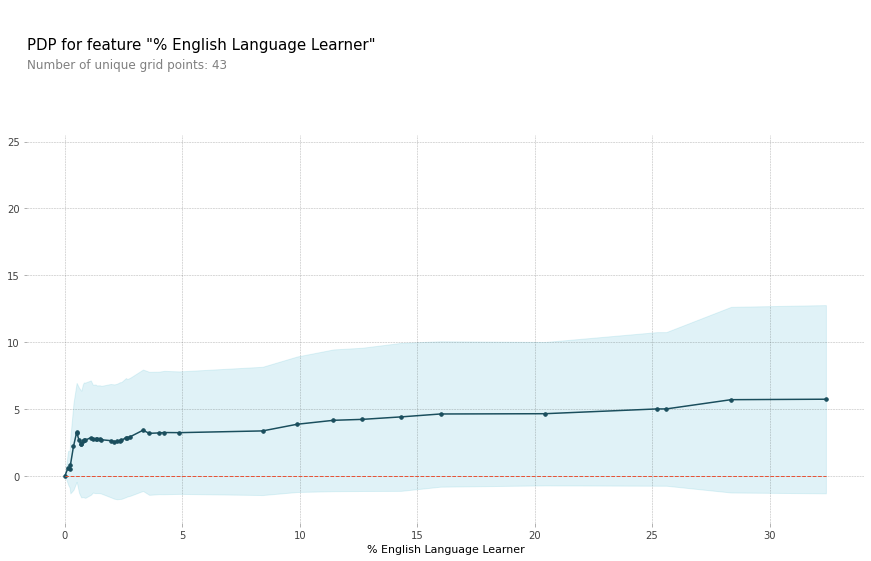

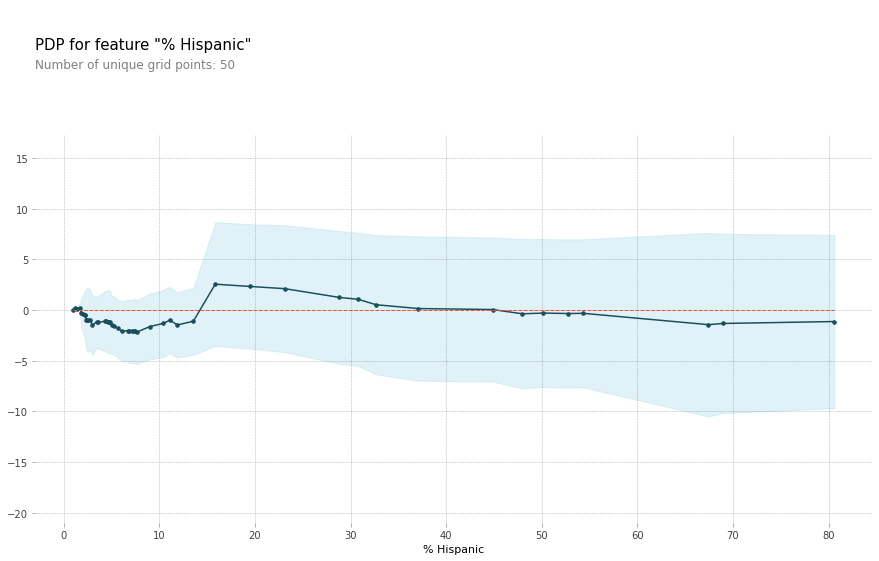

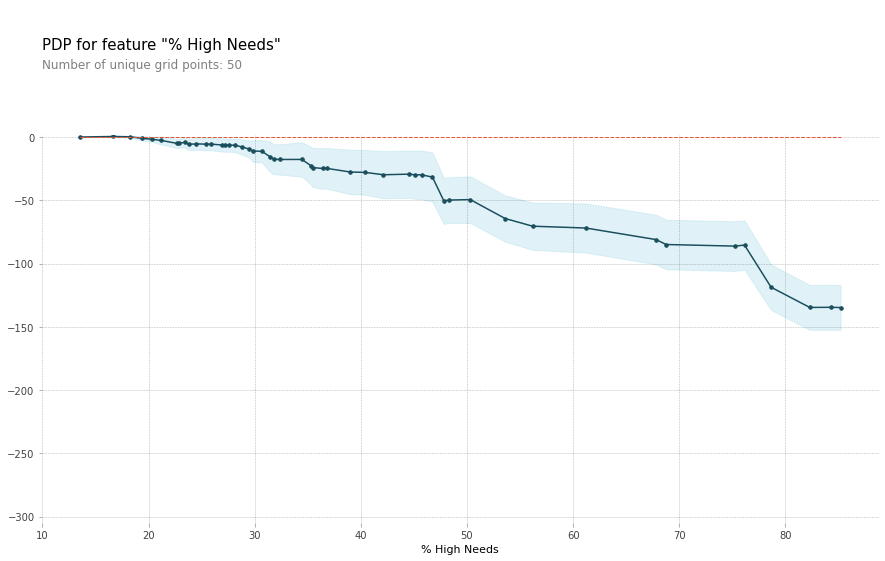

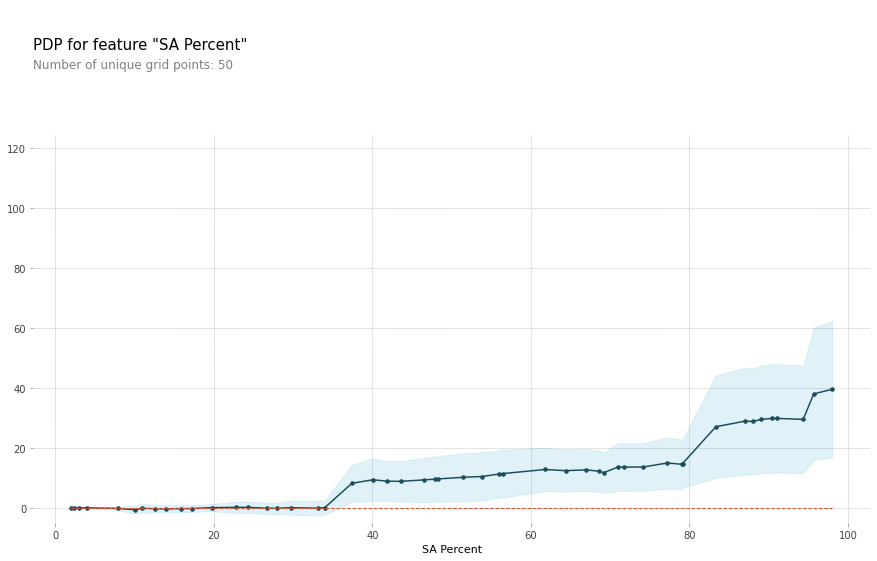

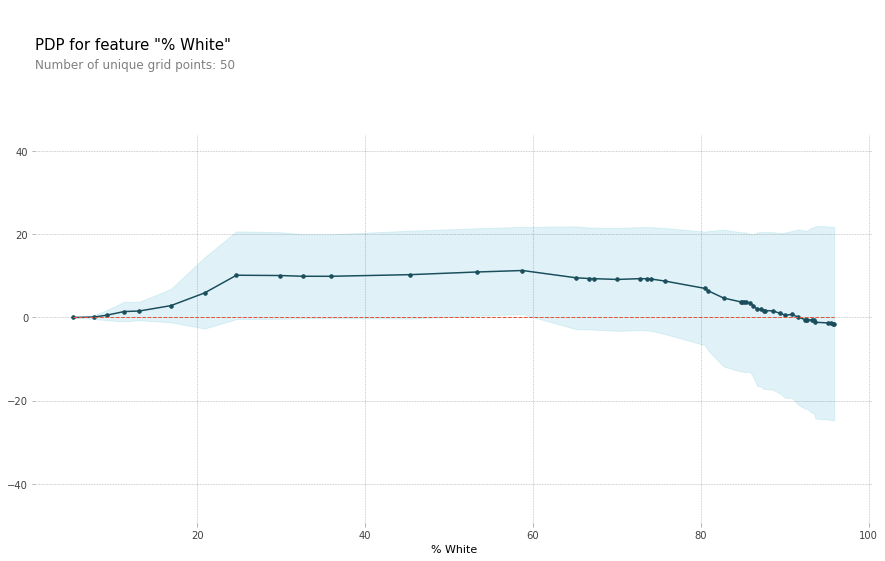

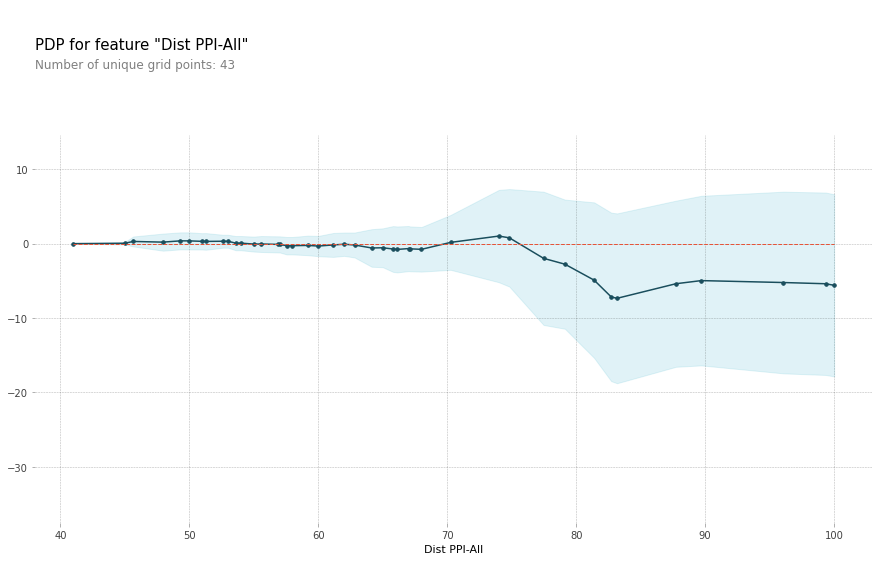

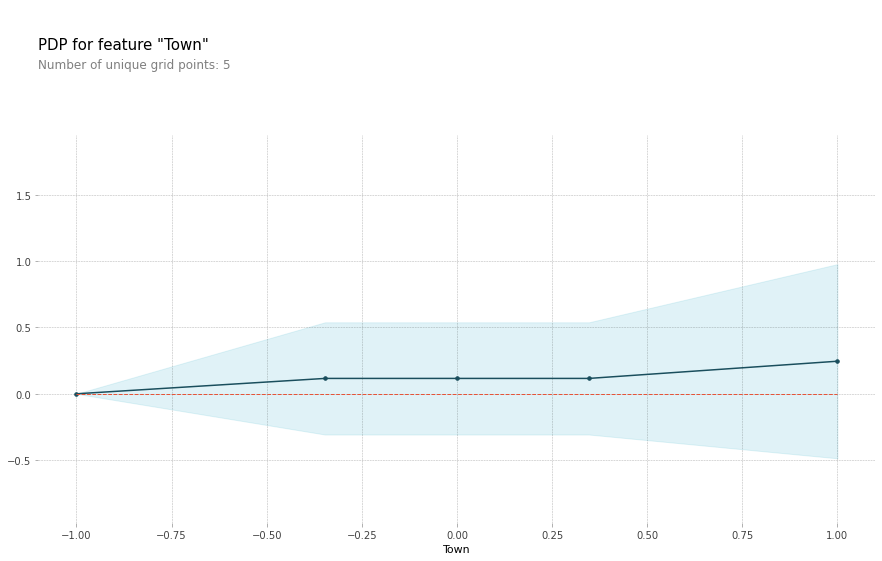

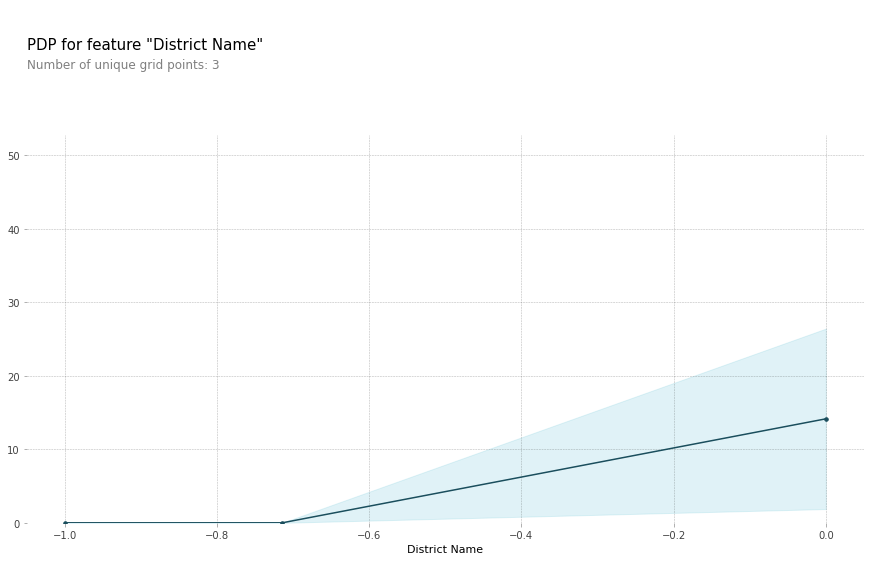

In [431]:
features = Score_anal.columns.drop(['SAT Scale and Sum'])
target = 'SAT Scale and Sum'
pdp(Score_anal, features, target, preprocess)

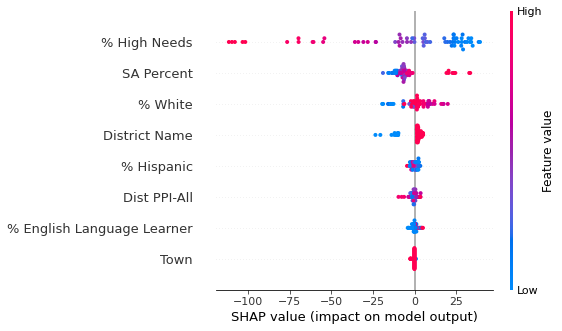

In [433]:
reg_shap(Score_anal, features, target)

In [ ]:
#sns.pairplot(Score_anal)
plt.title("summary")
plt.show()

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer

regressor = RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)

tt = TransformedTargetRegressor(regressor=regressor,
                                transformer=PowerTransformer(method='box-cox', standardize=False))
tt.fit(X_train, y_train)
y_pred = tt.predict(X_test)